In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/RADIOLOGÍA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 10 questions
Page 1, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=118.9, y1=127.3
Page 1, Q1, A: Yellow pixels: 113
Page 1, Q1, A: Total non-white pixels: 384
Page 1, Q1, A: Yellow percentage: 29.4%


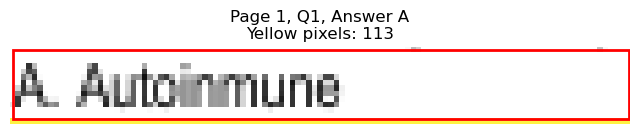

Page 1, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=101.9, y1=139.9
Page 1, Q1, B: Yellow pixels: 1097
Page 1, Q1, B: Total non-white pixels: 1248
Page 1, Q1, B: Yellow percentage: 87.9%


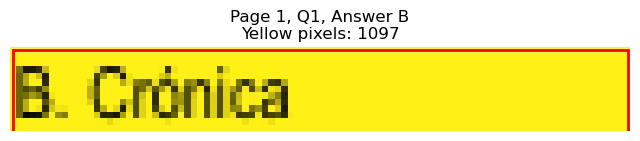

Page 1, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=356.1, y1=127.3
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 171
Page 1, Q1, C: Yellow percentage: 0.0%


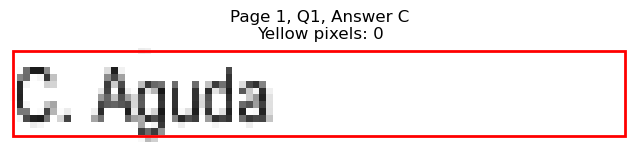

Page 1, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=368.2, y1=139.9
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 235
Page 1, Q1, D: Yellow percentage: 0.0%


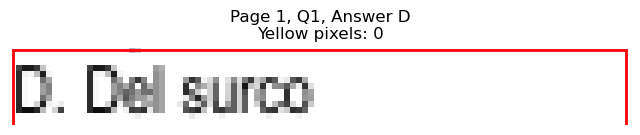


Page 1, Q1 - Selected Answer: B (based on yellow pixel count)
Page 1, Q2 - A: Detected box: x0=56.6, y0=177.7, x1=121.0, y1=190.4
Page 1, Q2, A: Yellow pixels: 115
Page 1, Q2, A: Total non-white pixels: 413
Page 1, Q2, A: Yellow percentage: 27.8%


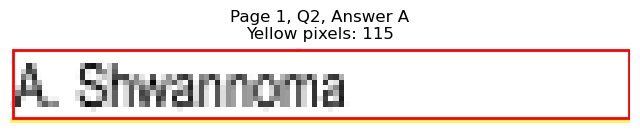

Page 1, Q2 - B: Detected box: x0=56.6, y0=190.3, x1=124.9, y1=203.0
Page 1, Q2, B: Yellow pixels: 1307
Page 1, Q2, B: Total non-white pixels: 1547
Page 1, Q2, B: Yellow percentage: 84.5%


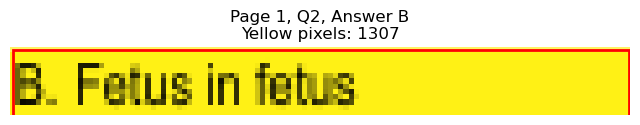

Page 1, Q2 - C: Detected box: x0=315.4, y0=177.7, x1=412.9, y1=190.4
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 456
Page 1, Q2, C: Yellow percentage: 0.0%


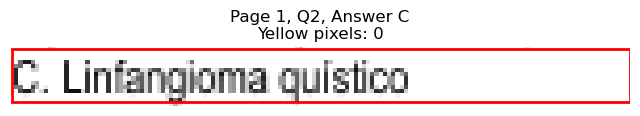

Page 1, Q2 - D: Detected box: x0=315.4, y0=190.3, x1=381.7, y1=203.0
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 289
Page 1, Q2, D: Yellow percentage: 0.0%


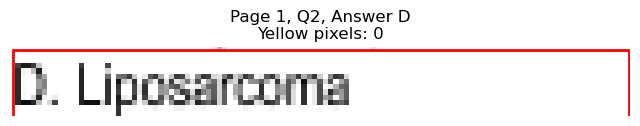


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)
Page 1, Q3 - A: Detected box: x0=56.6, y0=240.8, x1=103.5, y1=253.5
Page 1, Q3, A: Yellow pixels: 1092
Page 1, Q3, A: Total non-white pixels: 1372
Page 1, Q3, A: Yellow percentage: 79.6%


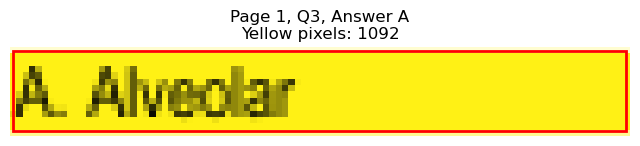

Page 1, Q3 - B: Detected box: x0=56.6, y0=253.4, x1=106.5, y1=266.1
Page 1, Q3, B: Yellow pixels: 101
Page 1, Q3, B: Total non-white pixels: 354
Page 1, Q3, B: Yellow percentage: 28.5%


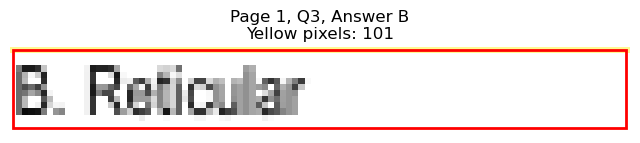

Page 1, Q3 - C: Detected box: x0=315.4, y0=240.8, x1=397.7, y1=253.5
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 397
Page 1, Q3, C: Yellow percentage: 0.0%


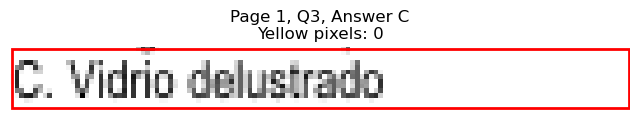

Page 1, Q3 - D: Detected box: x0=315.4, y0=253.4, x1=376.7, y1=266.1
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 292
Page 1, Q3, D: Yellow percentage: 0.0%


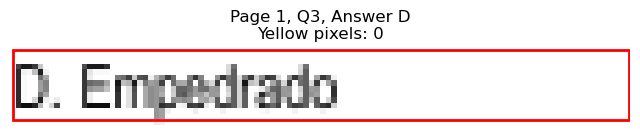


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)
Page 1, Q4 - A: Detected box: x0=56.6, y0=304.0, x1=157.1, y1=316.6
Page 1, Q4, A: Yellow pixels: 1583
Page 1, Q4, A: Total non-white pixels: 1979
Page 1, Q4, A: Yellow percentage: 80.0%


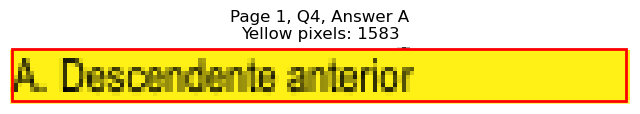

Page 1, Q4 - B: Detected box: x0=56.6, y0=316.6, x1=145.6, y1=329.2
Page 1, Q4, B: Yellow pixels: 140
Page 1, Q4, B: Total non-white pixels: 563
Page 1, Q4, B: Yellow percentage: 24.9%


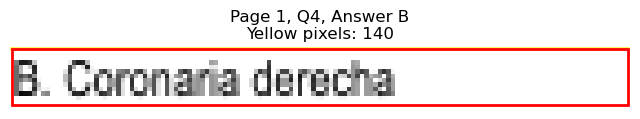

Page 1, Q4 - C: Detected box: x0=315.4, y0=304.0, x1=372.7, y1=316.6
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 277
Page 1, Q4, C: Yellow percentage: 0.0%


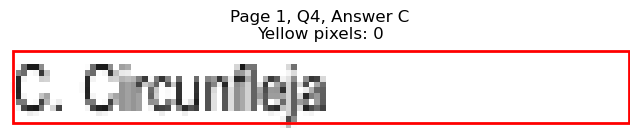

Page 1, Q4 - D: Detected box: x0=315.4, y0=316.6, x1=427.4, y1=329.2
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 554
Page 1, Q4, D: Yellow percentage: 0.0%


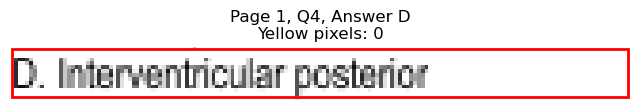


Page 1, Q4 - Selected Answer: A (based on yellow pixel count)
Page 1, Q5 - A: Detected box: x0=56.6, y0=379.7, x1=272.2, y1=392.4
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 1035
Page 1, Q5, A: Yellow percentage: 0.0%


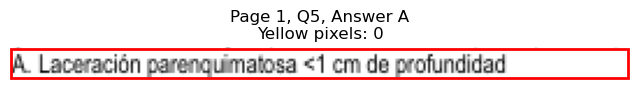

Page 1, Q5 - B: Detected box: x0=56.6, y0=392.3, x1=307.1, y1=405.0
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 1150
Page 1, Q5, B: Yellow percentage: 0.0%


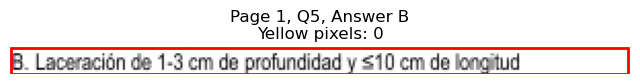

Page 1, Q5 - C: Detected box: x0=56.6, y0=404.9, x1=207.0, y1=417.6
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 744
Page 1, Q5, C: Yellow percentage: 0.0%


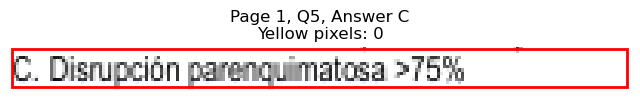

Page 1, Q5 - D: Detected box: x0=56.6, y0=417.6, x1=269.1, y1=430.3
Page 1, Q5, D: Yellow pixels: 2337
Page 1, Q5, D: Total non-white pixels: 3696
Page 1, Q5, D: Yellow percentage: 63.2%


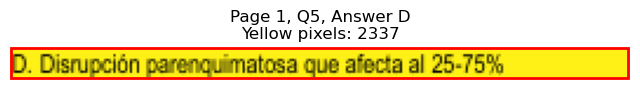


Page 1, Q5 - Selected Answer: D (based on yellow pixel count)
Page 1, Q6 - A: Detected box: x0=56.6, y0=480.8, x1=113.9, y1=493.4
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 308
Page 1, Q6, A: Yellow percentage: 0.0%


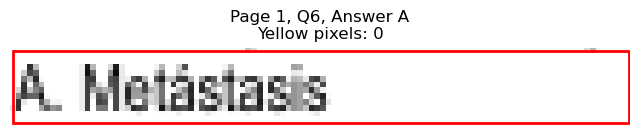

Page 1, Q6 - B: Detected box: x0=56.6, y0=493.4, x1=105.4, y1=506.0
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 232
Page 1, Q6, B: Yellow percentage: 0.0%


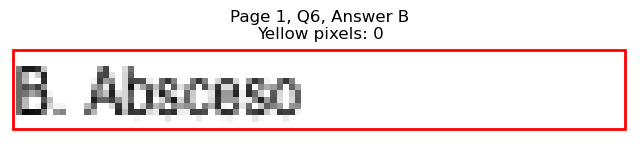

Page 1, Q6 - C: Detected box: x0=315.4, y0=480.8, x1=377.7, y1=493.4
Page 1, Q6, C: Yellow pixels: 1134
Page 1, Q6, C: Total non-white pixels: 1582
Page 1, Q6, C: Yellow percentage: 71.7%


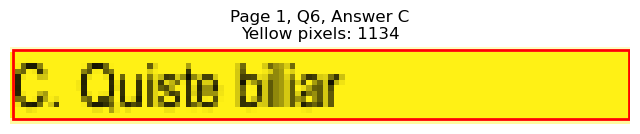

Page 1, Q6 - D: Detected box: x0=315.4, y0=493.4, x1=383.7, y1=506.0
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 435
Page 1, Q6, D: Yellow percentage: 0.0%


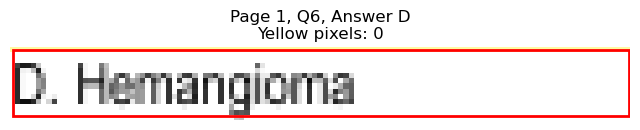


Page 1, Q6 - Selected Answer: C (based on yellow pixel count)
Page 1, Q7 - A: Detected box: x0=56.6, y0=543.8, x1=79.3, y1=556.4
Page 1, Q7, A: Yellow pixels: 903
Page 1, Q7, A: Total non-white pixels: 1036
Page 1, Q7, A: Yellow percentage: 87.2%


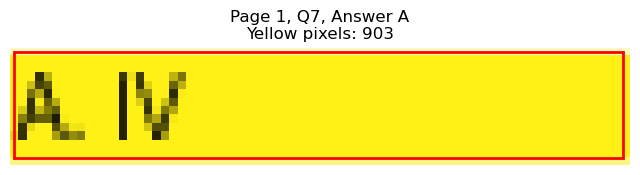

Page 1, Q7 - B: Detected box: x0=56.6, y0=556.5, x1=75.9, y1=569.1
Page 1, Q7, B: Yellow pixels: 70
Page 1, Q7, B: Total non-white pixels: 136
Page 1, Q7, B: Yellow percentage: 51.5%


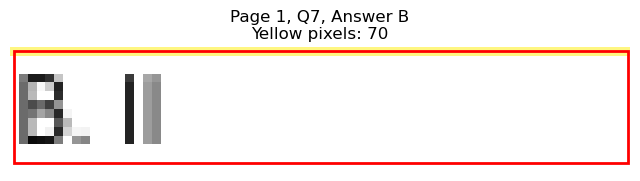

Page 1, Q7 - C: Detected box: x0=315.4, y0=543.8, x1=340.6, y1=556.4
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 95
Page 1, Q7, C: Yellow percentage: 0.0%


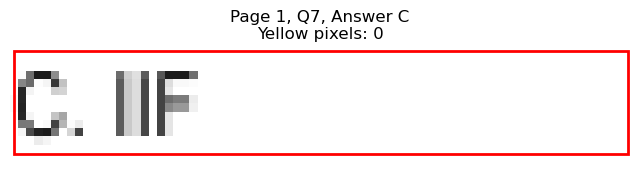

Page 1, Q7 - D: Detected box: x0=315.4, y0=556.5, x1=332.6, y1=569.1
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 56
Page 1, Q7, D: Yellow percentage: 0.0%


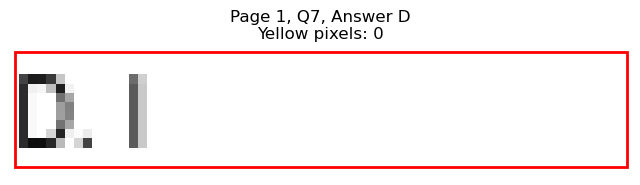


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)
Page 1, Q8 - A: Detected box: x0=56.6, y0=619.6, x1=137.5, y1=632.3
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 360
Page 1, Q8, A: Yellow percentage: 0.0%


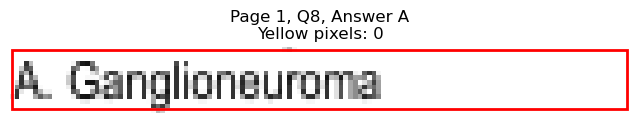

Page 1, Q8 - B: Detected box: x0=56.6, y0=632.2, x1=128.5, y1=644.9
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 347
Page 1, Q8, B: Yellow percentage: 0.0%


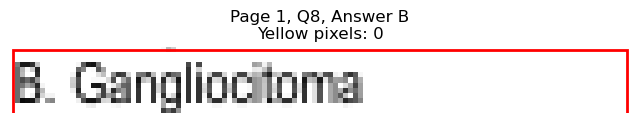

Page 1, Q8 - C: Detected box: x0=315.4, y0=619.6, x1=387.8, y1=632.3
Page 1, Q8, C: Yellow pixels: 123
Page 1, Q8, C: Total non-white pixels: 487
Page 1, Q8, C: Yellow percentage: 25.3%


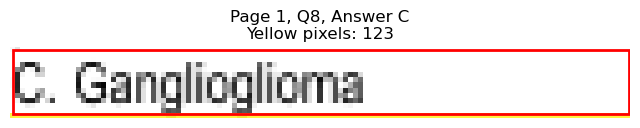

Page 1, Q8 - D: Detected box: x0=315.4, y0=632.2, x1=405.8, y1=644.9
Page 1, Q8, D: Yellow pixels: 1515
Page 1, Q8, D: Total non-white pixels: 1833
Page 1, Q8, D: Yellow percentage: 82.7%


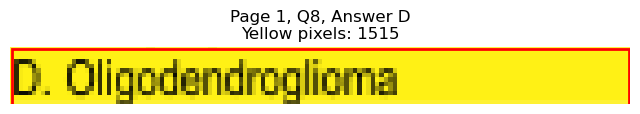


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)
Page 1, Q9 - A: Detected box: x0=56.6, y0=670.0, x1=173.7, y1=682.7
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 501
Page 1, Q9, A: Yellow percentage: 0.0%


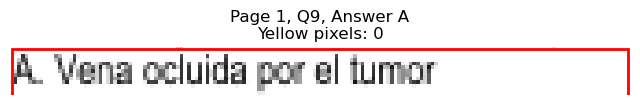

Page 1, Q9 - B: Detected box: x0=56.6, y0=682.6, x1=194.2, y1=695.3
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 647
Page 1, Q9, B: Yellow percentage: 0.0%


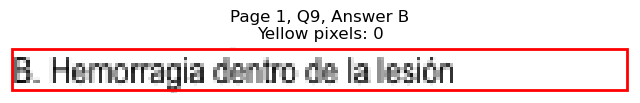

Page 1, Q9 - C: Detected box: x0=315.4, y0=670.0, x1=427.4, y1=682.7
Page 1, Q9, C: Yellow pixels: 1
Page 1, Q9, C: Total non-white pixels: 680
Page 1, Q9, C: Yellow percentage: 0.1%


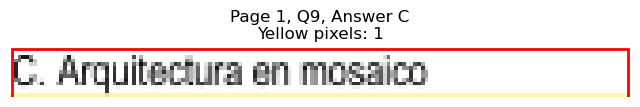

Page 1, Q9 - D: Detected box: x0=315.4, y0=682.6, x1=471.0, y1=695.3
Page 1, Q9, D: Yellow pixels: 1867
Page 1, Q9, D: Total non-white pixels: 2884
Page 1, Q9, D: Yellow percentage: 64.7%


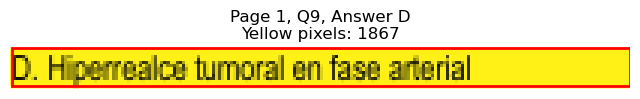


Page 1, Q9 - Selected Answer: D (based on yellow pixel count)
Page 1, Q10 - A: Detected box: x0=56.6, y0=733.2, x1=147.5, y1=745.8
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 400
Page 1, Q10, A: Yellow percentage: 0.0%


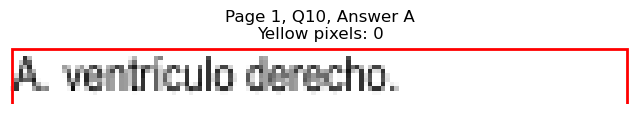

Page 1, Q10 - B: Detected box: x0=56.6, y0=745.8, x1=140.5, y1=758.4
Page 1, Q10, B: Yellow pixels: 0
Page 1, Q10, B: Total non-white pixels: 371
Page 1, Q10, B: Yellow percentage: 0.0%


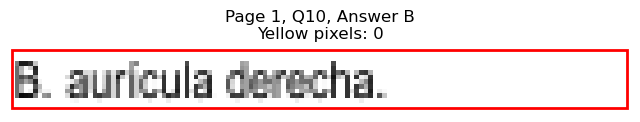

Page 1, Q10 - C: Detected box: x0=315.4, y0=733.2, x1=403.7, y1=745.8
Page 1, Q10, C: Yellow pixels: 1523
Page 1, Q10, C: Total non-white pixels: 1807
Page 1, Q10, C: Yellow percentage: 84.3%


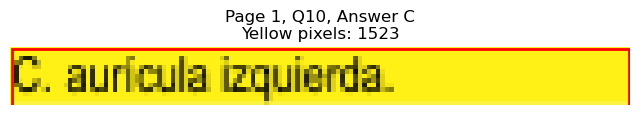

Page 1, Q10 - D: Detected box: x0=315.4, y0=745.8, x1=410.8, y1=758.4
Page 1, Q10, D: Yellow pixels: 146
Page 1, Q10, D: Total non-white pixels: 599
Page 1, Q10, D: Yellow percentage: 24.4%


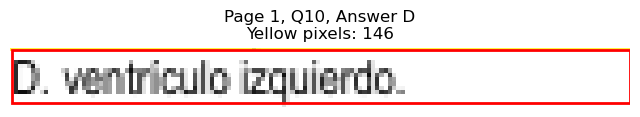


Page 1, Q10 - Selected Answer: C (based on yellow pixel count)

Page 2: Found 10 questions
Page 2, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=234.3, y1=114.7
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 889
Page 2, Q1, A: Yellow percentage: 0.0%


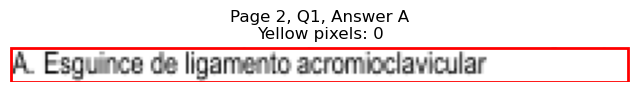

Page 2, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=312.5, y1=127.3
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 1240
Page 2, Q1, B: Yellow percentage: 0.0%


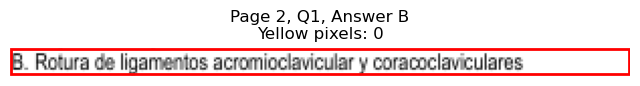

Page 2, Q1 - C: Detected box: x0=56.6, y0=127.2, x1=365.2, y1=139.9
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 1497
Page 2, Q1, C: Yellow percentage: 0.0%


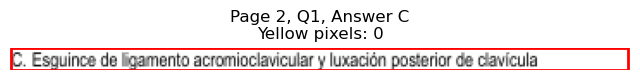

Page 2, Q1 - D: Detected box: x0=56.6, y0=139.9, x1=349.6, y1=152.6
Page 2, Q1, D: Yellow pixels: 3298
Page 2, Q1, D: Total non-white pixels: 4816
Page 2, Q1, D: Yellow percentage: 68.5%


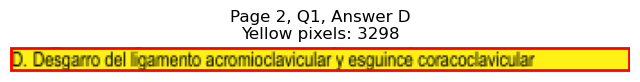


Page 2, Q1 - Selected Answer: D (based on yellow pixel count)
Page 2, Q2 - A: Detected box: x0=56.6, y0=190.3, x1=180.1, y1=203.0
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 748
Page 2, Q2, A: Yellow percentage: 0.0%


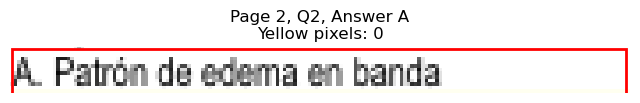

Page 2, Q2 - B: Detected box: x0=56.6, y0=202.9, x1=131.1, y1=215.6
Page 2, Q2, B: Yellow pixels: 1369
Page 2, Q2, B: Total non-white pixels: 1764
Page 2, Q2, B: Yellow percentage: 77.6%


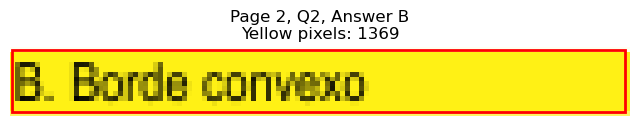

Page 2, Q2 - C: Detected box: x0=315.4, y0=190.3, x1=418.4, y1=203.0
Page 2, Q2, C: Yellow pixels: 0
Page 2, Q2, C: Total non-white pixels: 504
Page 2, Q2, C: Yellow percentage: 0.0%


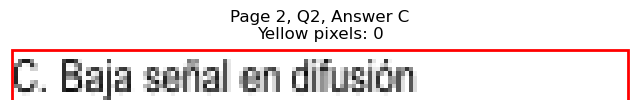

Page 2, Q2 - D: Detected box: x0=315.4, y0=202.9, x1=447.5, y1=215.6
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 585
Page 2, Q2, D: Yellow percentage: 0.0%


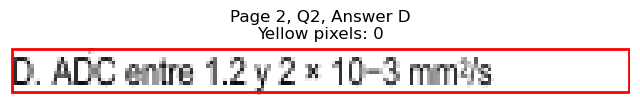


Page 2, Q2 - Selected Answer: B (based on yellow pixel count)
Page 2, Q3 - A: Detected box: x0=56.6, y0=253.4, x1=179.7, y1=266.1
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 550
Page 2, Q3, A: Yellow percentage: 0.0%


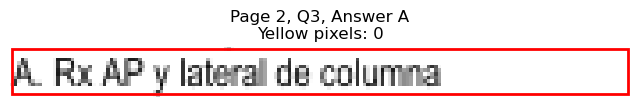

Page 2, Q3 - B: Detected box: x0=56.6, y0=266.0, x1=166.6, y1=278.7
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 521
Page 2, Q3, B: Yellow percentage: 0.0%


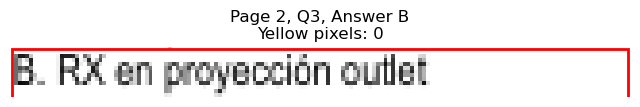

Page 2, Q3 - C: Detected box: x0=315.4, y0=253.4, x1=373.6, y1=266.1
Page 2, Q3, C: Yellow pixels: 1226
Page 2, Q3, C: Total non-white pixels: 1526
Page 2, Q3, C: Yellow percentage: 80.3%


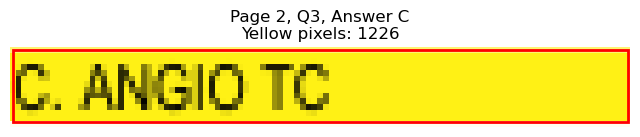

Page 2, Q3 - D: Detected box: x0=315.4, y0=266.0, x1=350.6, y1=278.7
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 246
Page 2, Q3, D: Yellow percentage: 0.0%


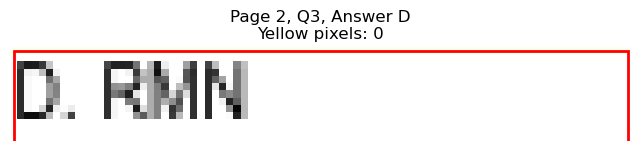


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)
Page 2, Q4 - A: Detected box: x0=56.6, y0=316.6, x1=121.9, y1=329.2
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 304
Page 2, Q4, A: Yellow percentage: 0.0%


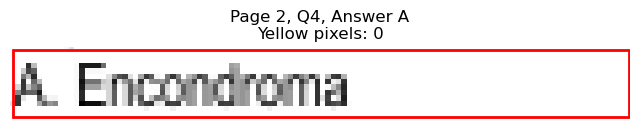

Page 2, Q4 - B: Detected box: x0=56.6, y0=329.2, x1=137.1, y1=341.8
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 400
Page 2, Q4, B: Yellow percentage: 0.0%


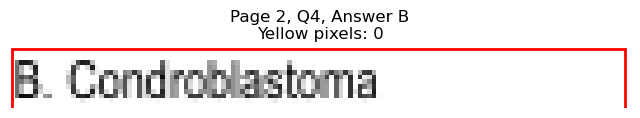

Page 2, Q4 - C: Detected box: x0=315.4, y0=316.6, x1=394.3, y1=329.2
Page 2, Q4, C: Yellow pixels: 1279
Page 2, Q4, C: Total non-white pixels: 1820
Page 2, Q4, C: Yellow percentage: 70.3%


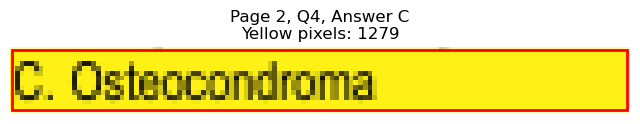

Page 2, Q4 - D: Detected box: x0=315.4, y0=329.2, x1=424.3, y1=341.8
Page 2, Q4, D: Yellow pixels: 0
Page 2, Q4, D: Total non-white pixels: 689
Page 2, Q4, D: Yellow percentage: 0.0%


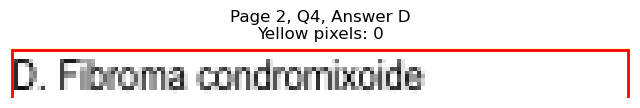


Page 2, Q4 - Selected Answer: C (based on yellow pixel count)
Page 2, Q5 - A: Detected box: x0=56.6, y0=367.1, x1=245.3, y1=379.8
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 972
Page 2, Q5, A: Yellow percentage: 0.0%


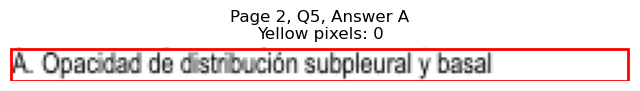

Page 2, Q5 - B: Detected box: x0=56.6, y0=379.7, x1=172.7, y1=392.4
Page 2, Q5, B: Yellow pixels: 167
Page 2, Q5, B: Total non-white pixels: 721
Page 2, Q5, B: Yellow percentage: 23.2%


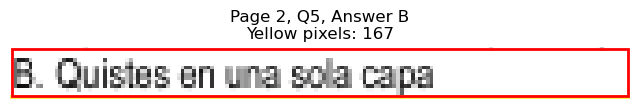

Page 2, Q5 - C: Detected box: x0=56.6, y0=392.3, x1=311.1, y1=405.0
Page 2, Q5, C: Yellow pixels: 3042
Page 2, Q5, C: Total non-white pixels: 3978
Page 2, Q5, C: Yellow percentage: 76.5%


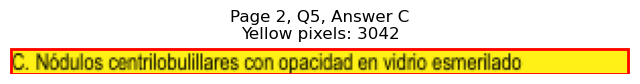

Page 2, Q5 - D: Detected box: x0=56.6, y0=404.9, x1=198.3, y1=417.6
Page 2, Q5, D: Yellow pixels: 192
Page 2, Q5, D: Total non-white pixels: 889
Page 2, Q5, D: Yellow percentage: 21.6%


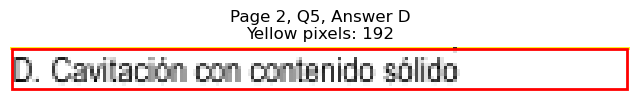


Page 2, Q5 - Selected Answer: C (based on yellow pixel count)
Page 2, Q6 - A: Detected box: x0=56.6, y0=442.8, x1=119.4, y1=455.5
Page 2, Q6, A: Yellow pixels: 114
Page 2, Q6, A: Total non-white pixels: 458
Page 2, Q6, A: Yellow percentage: 24.9%


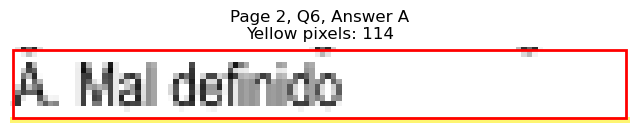

Page 2, Q6 - B: Detected box: x0=56.6, y0=455.5, x1=149.1, y1=468.1
Page 2, Q6, B: Yellow pixels: 1514
Page 2, Q6, B: Total non-white pixels: 2016
Page 2, Q6, B: Yellow percentage: 75.1%


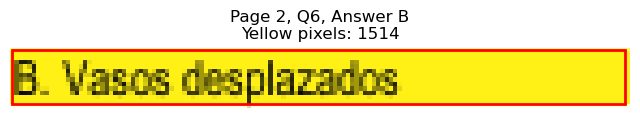

Page 2, Q6 - C: Detected box: x0=315.4, y0=442.8, x1=389.7, y1=455.5
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 352
Page 2, Q6, C: Yellow percentage: 0.0%


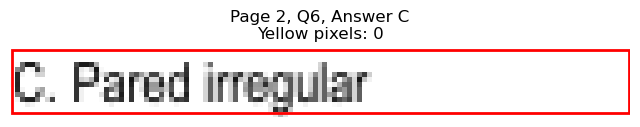

Page 2, Q6 - D: Detected box: x0=315.4, y0=455.5, x1=362.7, y1=468.1
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 223
Page 2, Q6, D: Yellow percentage: 0.0%


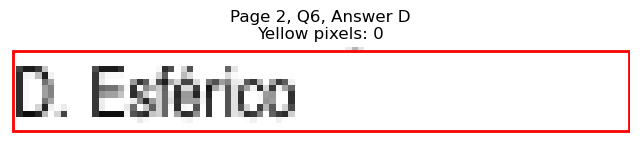


Page 2, Q6 - Selected Answer: B (based on yellow pixel count)
Page 2, Q7 - A: Detected box: x0=56.6, y0=493.4, x1=276.4, y1=506.0
Page 2, Q7, A: Yellow pixels: 225
Page 2, Q7, A: Total non-white pixels: 1564
Page 2, Q7, A: Yellow percentage: 14.4%


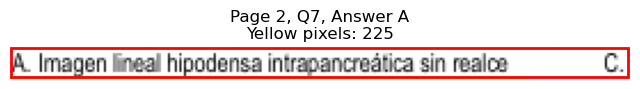

Page 2, Q7 - B: Detected box: x0=56.6, y0=506.0, x1=279.5, y1=518.6
Page 2, Q7, B: Yellow pixels: 2046
Page 2, Q7, B: Total non-white pixels: 3217
Page 2, Q7, B: Yellow percentage: 63.6%


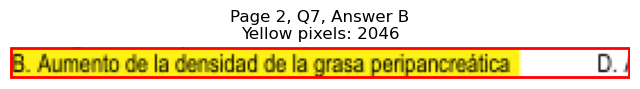

Page 2, Q7 - C: Detected box: x0=315.4, y0=493.4, x1=493.2, y1=506.0
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 898
Page 2, Q7, C: Yellow percentage: 0.0%


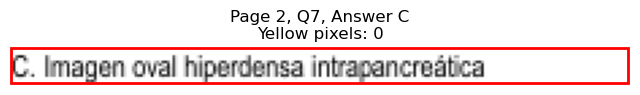

Page 2, Q7 - D: Detected box: x0=315.4, y0=506.0, x1=465.4, y1=518.6
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 731
Page 2, Q7, D: Yellow percentage: 0.0%


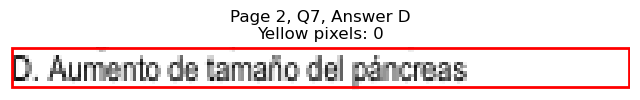


Page 2, Q7 - Selected Answer: B (based on yellow pixel count)
Page 2, Q8 - A: Detected box: x0=56.6, y0=569.1, x1=197.2, y1=581.7
Page 2, Q8, A: Yellow pixels: 1954
Page 2, Q8, A: Total non-white pixels: 2496
Page 2, Q8, A: Yellow percentage: 78.3%


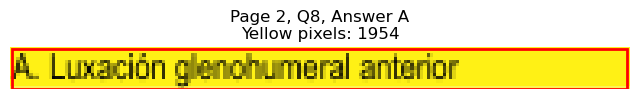

Page 2, Q8 - B: Detected box: x0=56.6, y0=581.7, x1=152.5, y1=594.3
Page 2, Q8, B: Yellow pixels: 146
Page 2, Q8, B: Total non-white pixels: 587
Page 2, Q8, B: Yellow percentage: 24.9%


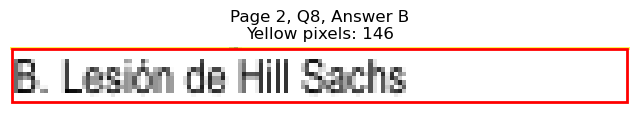

Page 2, Q8 - C: Detected box: x0=315.4, y0=569.1, x1=402.8, y1=581.7
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 415
Page 2, Q8, C: Yellow percentage: 0.0%


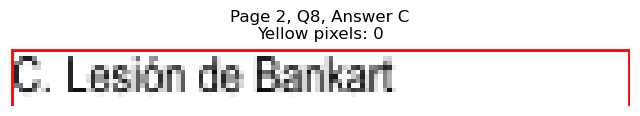

Page 2, Q8 - D: Detected box: x0=315.4, y0=581.7, x1=416.8, y1=594.3
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 461
Page 2, Q8, D: Yellow percentage: 0.0%


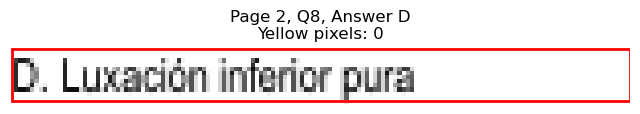


Page 2, Q8 - Selected Answer: A (based on yellow pixel count)
Page 2, Q9 - A: Detected box: x0=56.6, y0=619.6, x1=150.5, y1=632.3
Page 2, Q9, A: Yellow pixels: 145
Page 2, Q9, A: Total non-white pixels: 609
Page 2, Q9, A: Yellow percentage: 23.8%


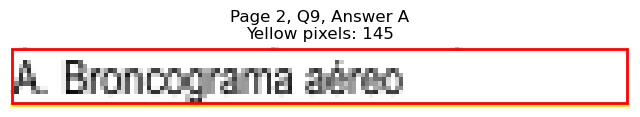

Page 2, Q9 - B: Detected box: x0=56.6, y0=632.2, x1=147.0, y1=644.9
Page 2, Q9, B: Yellow pixels: 1490
Page 2, Q9, B: Total non-white pixels: 1846
Page 2, Q9, B: Yellow percentage: 80.7%


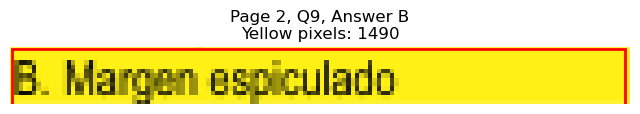

Page 2, Q9 - C: Detected box: x0=315.4, y0=619.6, x1=455.9, y1=632.3
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 690
Page 2, Q9, C: Yellow percentage: 0.0%


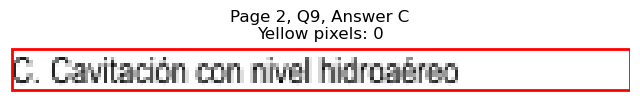

Page 2, Q9 - D: Detected box: x0=315.4, y0=632.2, x1=441.9, y1=644.9
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 654
Page 2, Q9, D: Yellow percentage: 0.0%


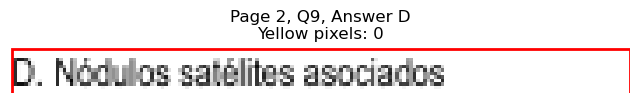


Page 2, Q9 - Selected Answer: B (based on yellow pixel count)
Page 2, Q10 - A: Detected box: x0=56.6, y0=695.4, x1=79.3, y1=708.0
Page 2, Q10, A: Yellow pixels: 903
Page 2, Q10, A: Total non-white pixels: 962
Page 2, Q10, A: Yellow percentage: 93.9%


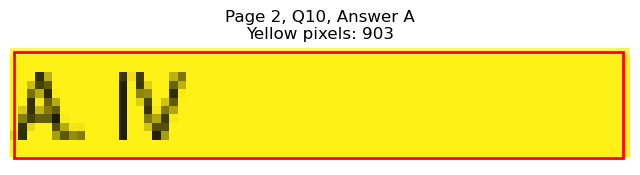

Page 2, Q10 - B: Detected box: x0=56.6, y0=708.0, x1=73.3, y1=720.6
Page 2, Q10, B: Yellow pixels: 68
Page 2, Q10, B: Total non-white pixels: 118
Page 2, Q10, B: Yellow percentage: 57.6%


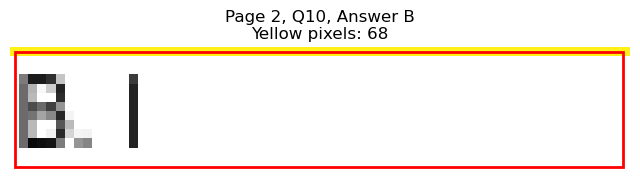

Page 2, Q10 - C: Detected box: x0=315.4, y0=695.4, x1=335.1, y1=708.0
Page 2, Q10, C: Yellow pixels: 0
Page 2, Q10, C: Total non-white pixels: 68
Page 2, Q10, C: Yellow percentage: 0.0%


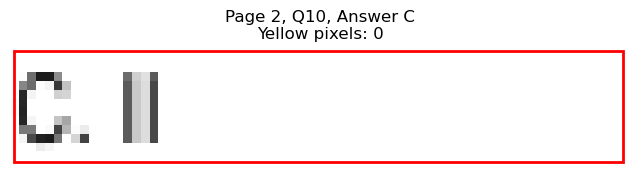

Page 2, Q10 - D: Detected box: x0=315.4, y0=708.0, x1=336.1, y1=720.6
Page 2, Q10, D: Yellow pixels: 0
Page 2, Q10, D: Total non-white pixels: 69
Page 2, Q10, D: Yellow percentage: 0.0%


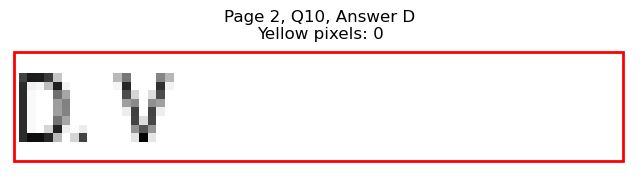


Page 2, Q10 - Selected Answer: A (based on yellow pixel count)

Page 3: Found 10 questions
Page 3, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=143.1, y1=114.7
Page 3, Q1, A: Yellow pixels: 1
Page 3, Q1, A: Total non-white pixels: 509
Page 3, Q1, A: Yellow percentage: 0.2%


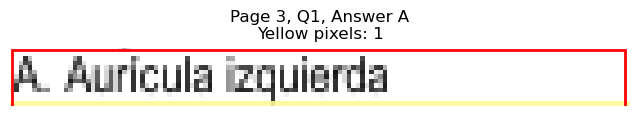

Page 3, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=146.5, y1=127.3
Page 3, Q1, B: Yellow pixels: 1359
Page 3, Q1, B: Total non-white pixels: 1974
Page 3, Q1, B: Yellow percentage: 68.8%


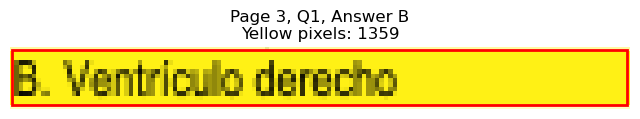

Page 3, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=409.7, y1=114.7
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 450
Page 3, Q1, C: Yellow percentage: 0.0%


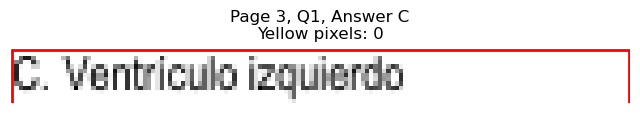

Page 3, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=398.2, y1=127.3
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 381
Page 3, Q1, D: Yellow percentage: 0.0%


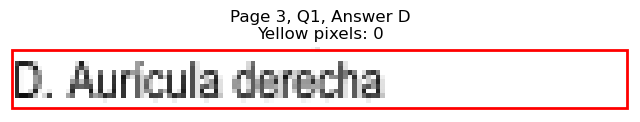


Page 3, Q1 - Selected Answer: B (based on yellow pixel count)
Page 3, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=228.8, y1=177.8
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 825
Page 3, Q2, A: Yellow percentage: 0.0%


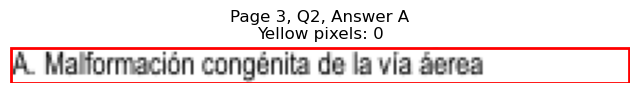

Page 3, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=154.1, y1=190.4
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 478
Page 3, Q2, B: Yellow percentage: 0.0%


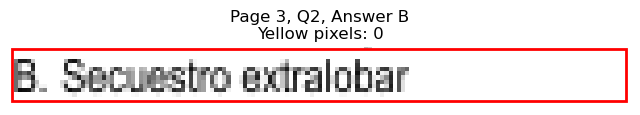

Page 3, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=469.5, y1=177.8
Page 3, Q2, C: Yellow pixels: 1
Page 3, Q2, C: Total non-white pixels: 990
Page 3, Q2, C: Yellow percentage: 0.1%


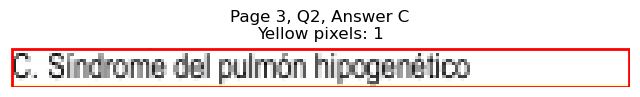

Page 3, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=410.8, y1=190.4
Page 3, Q2, D: Yellow pixels: 1377
Page 3, Q2, D: Total non-white pixels: 2044
Page 3, Q2, D: Yellow percentage: 67.4%


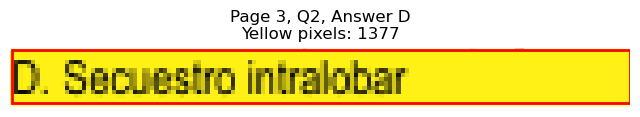


Page 3, Q2 - Selected Answer: D (based on yellow pixel count)
Page 3, Q3 - A: Detected box: x0=56.6, y0=240.8, x1=112.9, y1=253.5
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 287
Page 3, Q3, A: Yellow percentage: 0.0%


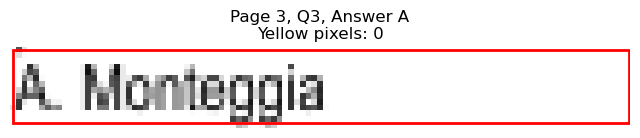

Page 3, Q3 - B: Detected box: x0=56.6, y0=253.4, x1=107.9, y1=266.1
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 245
Page 3, Q3, B: Yellow percentage: 0.0%


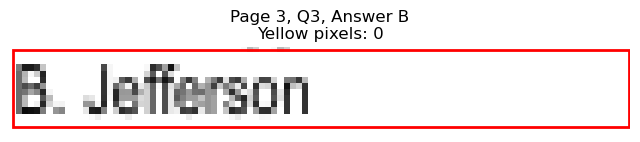

Page 3, Q3 - C: Detected box: x0=315.4, y0=240.8, x1=365.2, y1=253.5
Page 3, Q3, C: Yellow pixels: 1153
Page 3, Q3, C: Total non-white pixels: 1414
Page 3, Q3, C: Yellow percentage: 81.5%


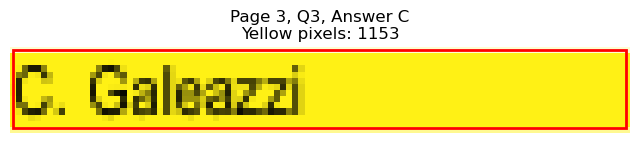

Page 3, Q3 - D: Detected box: x0=315.4, y0=253.4, x1=351.2, y1=266.1
Page 3, Q3, D: Yellow pixels: 87
Page 3, Q3, D: Total non-white pixels: 243
Page 3, Q3, D: Yellow percentage: 35.8%


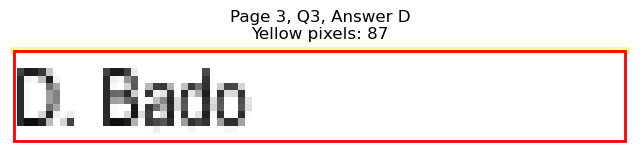


Page 3, Q3 - Selected Answer: C (based on yellow pixel count)
Page 3, Q4 - A: Detected box: x0=56.6, y0=316.6, x1=126.5, y1=329.2
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 317
Page 3, Q4, A: Yellow percentage: 0.0%


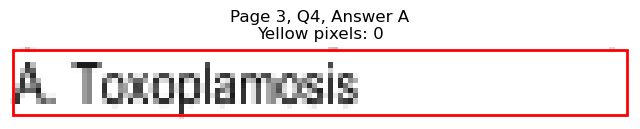

Page 3, Q4 - B: Detected box: x0=56.6, y0=329.2, x1=176.1, y1=341.8
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 601
Page 3, Q4, B: Yellow percentage: 0.0%


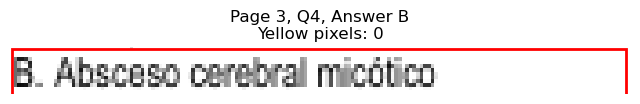

Page 3, Q4 - C: Detected box: x0=315.4, y0=316.6, x1=380.7, y1=329.2
Page 3, Q4, C: Yellow pixels: 116
Page 3, Q4, C: Total non-white pixels: 439
Page 3, Q4, C: Yellow percentage: 26.4%


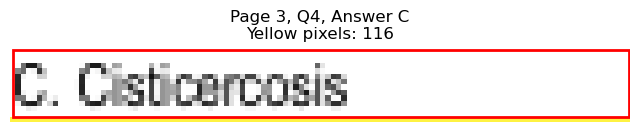

Page 3, Q4 - D: Detected box: x0=315.4, y0=329.2, x1=433.9, y1=341.8
Page 3, Q4, D: Yellow pixels: 1746
Page 3, Q4, D: Total non-white pixels: 2197
Page 3, Q4, D: Yellow percentage: 79.5%


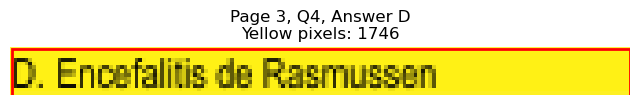


Page 3, Q4 - Selected Answer: D (based on yellow pixel count)
Page 3, Q5 - A: Detected box: x0=56.6, y0=392.3, x1=146.1, y1=405.0
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 438
Page 3, Q5, A: Yellow percentage: 0.0%


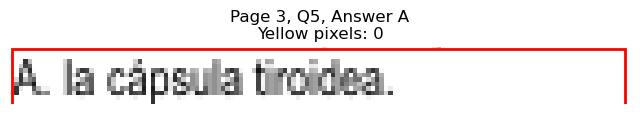

Page 3, Q5 - B: Detected box: x0=56.6, y0=404.9, x1=154.6, y1=417.6
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 461
Page 3, Q5, B: Yellow percentage: 0.0%


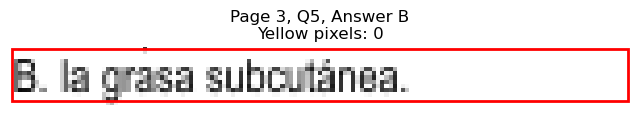

Page 3, Q5 - C: Detected box: x0=315.4, y0=392.3, x1=468.0, y1=405.0
Page 3, Q5, C: Yellow pixels: 2102
Page 3, Q5, C: Total non-white pixels: 2639
Page 3, Q5, C: Yellow percentage: 79.7%


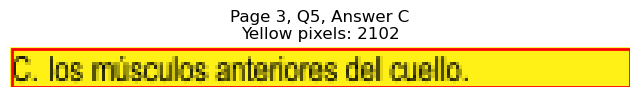

Page 3, Q5 - D: Detected box: x0=315.4, y0=404.9, x1=371.2, y1=417.6
Page 3, Q5, D: Yellow pixels: 107
Page 3, Q5, D: Total non-white pixels: 345
Page 3, Q5, D: Yellow percentage: 31.0%


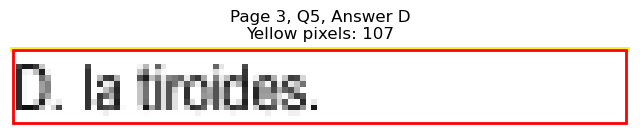


Page 3, Q5 - Selected Answer: C (based on yellow pixel count)
Page 3, Q6 - A: Detected box: x0=56.6, y0=468.1, x1=117.5, y1=480.7
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 300
Page 3, Q6, A: Yellow percentage: 0.0%


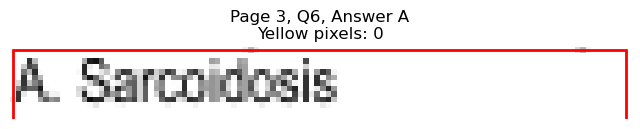

Page 3, Q6 - B: Detected box: x0=56.6, y0=480.8, x1=113.9, y1=493.4
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 310
Page 3, Q6, B: Yellow percentage: 0.0%


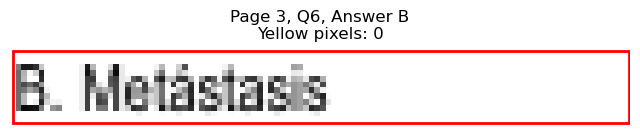

Page 3, Q6 - C: Detected box: x0=315.4, y0=468.1, x1=408.8, y1=480.7
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 439
Page 3, Q6, C: Yellow percentage: 0.0%


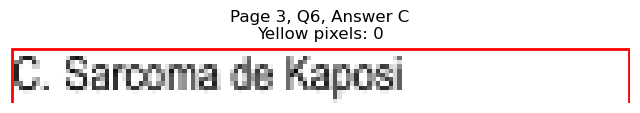

Page 3, Q6 - D: Detected box: x0=315.4, y0=480.8, x1=390.2, y1=493.4
Page 3, Q6, D: Yellow pixels: 1222
Page 3, Q6, D: Total non-white pixels: 1764
Page 3, Q6, D: Yellow percentage: 69.3%


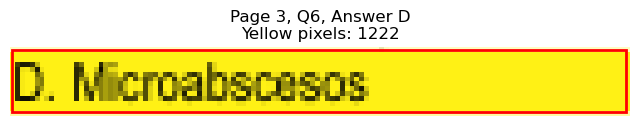


Page 3, Q6 - Selected Answer: D (based on yellow pixel count)
Page 3, Q7 - A: Detected box: x0=56.6, y0=531.2, x1=96.9, y1=543.8
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 152
Page 3, Q7, A: Yellow percentage: 0.0%


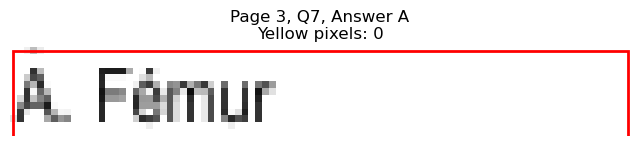

Page 3, Q7 - B: Detected box: x0=56.6, y0=543.8, x1=110.9, y1=556.4
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 250
Page 3, Q7, B: Yellow percentage: 0.0%


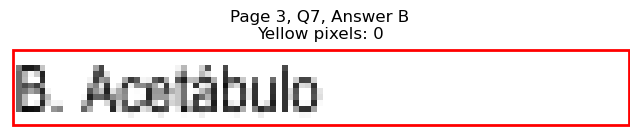

Page 3, Q7 - C: Detected box: x0=315.4, y0=531.2, x1=352.6, y1=543.8
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 239
Page 3, Q7, C: Yellow percentage: 0.0%


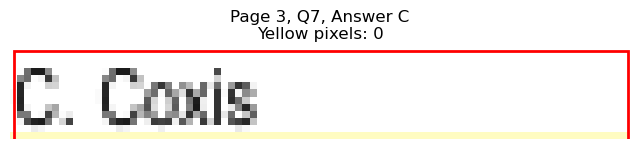

Page 3, Q7 - D: Detected box: x0=315.4, y0=543.8, x1=367.6, y1=556.4
Page 3, Q7, D: Yellow pixels: 1167
Page 3, Q7, D: Total non-white pixels: 1442
Page 3, Q7, D: Yellow percentage: 80.9%


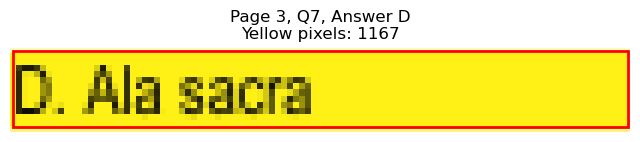


Page 3, Q7 - Selected Answer: D (based on yellow pixel count)
Page 3, Q8 - A: Detected box: x0=56.6, y0=581.7, x1=200.2, y1=594.3
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 662
Page 3, Q8, A: Yellow percentage: 0.0%


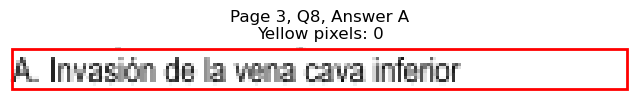

Page 3, Q8 - B: Detected box: x0=56.6, y0=594.3, x1=369.3, y1=606.9
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 1863
Page 3, Q8, B: Yellow percentage: 0.0%


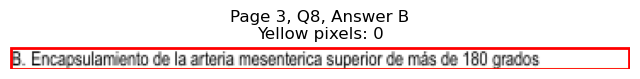

Page 3, Q8 - C: Detected box: x0=56.6, y0=606.9, x1=369.8, y1=619.5
Page 3, Q8, C: Yellow pixels: 3545
Page 3, Q8, C: Total non-white pixels: 5096
Page 3, Q8, C: Yellow percentage: 69.6%


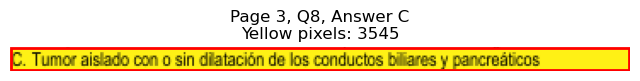

Page 3, Q8 - D: Detected box: x0=56.6, y0=619.6, x1=310.5, y1=632.3
Page 3, Q8, D: Yellow pixels: 304
Page 3, Q8, D: Total non-white pixels: 1520
Page 3, Q8, D: Yellow percentage: 20.0%


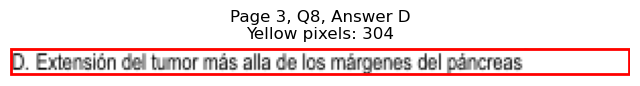


Page 3, Q8 - Selected Answer: C (based on yellow pixel count)
Page 3, Q9 - A: Detected box: x0=56.6, y0=657.4, x1=118.5, y1=670.1
Page 3, Q9, A: Yellow pixels: 1253
Page 3, Q9, A: Total non-white pixels: 1582
Page 3, Q9, A: Yellow percentage: 79.2%


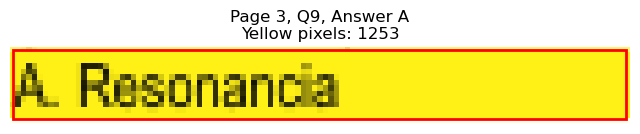

Page 3, Q9 - B: Detected box: x0=56.6, y0=670.0, x1=117.5, y1=682.7
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 436
Page 3, Q9, B: Yellow percentage: 0.0%


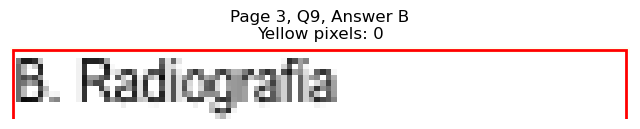

Page 3, Q9 - C: Detected box: x0=315.4, y0=657.4, x1=368.7, y1=670.1
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 257
Page 3, Q9, C: Yellow percentage: 0.0%


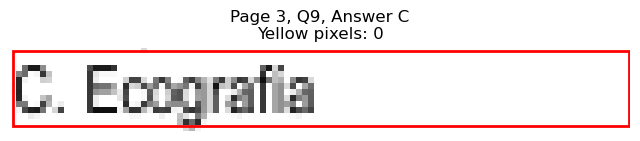

Page 3, Q9 - D: Detected box: x0=315.4, y0=670.0, x1=376.1, y1=682.7
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 283
Page 3, Q9, D: Yellow percentage: 0.0%


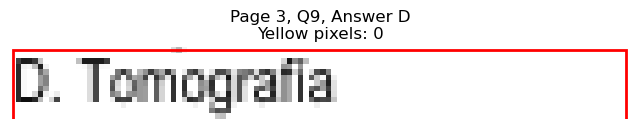


Page 3, Q9 - Selected Answer: A (based on yellow pixel count)
Page 3, Q10 - A: Detected box: x0=56.6, y0=720.6, x1=85.3, y1=733.2
Page 3, Q10, A: Yellow pixels: 0
Page 3, Q10, A: Total non-white pixels: 119
Page 3, Q10, A: Yellow percentage: 0.0%


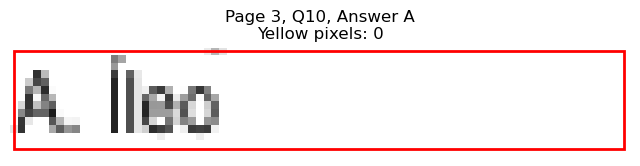

Page 3, Q10 - B: Detected box: x0=56.6, y0=733.2, x1=157.1, y1=745.8
Page 3, Q10, B: Yellow pixels: 0
Page 3, Q10, B: Total non-white pixels: 474
Page 3, Q10, B: Yellow percentage: 0.0%


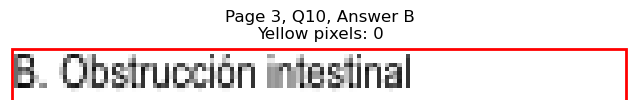

Page 3, Q10 - C: Detected box: x0=315.4, y0=720.6, x1=377.7, y1=733.2
Page 3, Q10, C: Yellow pixels: 113
Page 3, Q10, C: Total non-white pixels: 403
Page 3, Q10, C: Yellow percentage: 28.0%


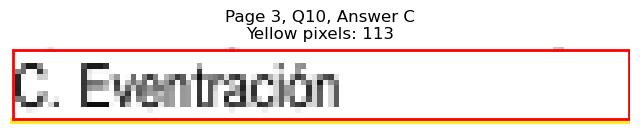

Page 3, Q10 - D: Detected box: x0=315.4, y0=733.2, x1=396.8, y1=745.8
Page 3, Q10, D: Yellow pixels: 1395
Page 3, Q10, D: Total non-white pixels: 1716
Page 3, Q10, D: Yellow percentage: 81.3%


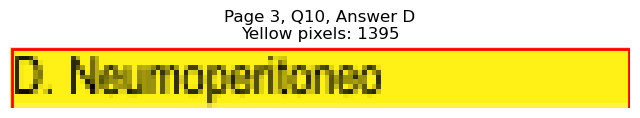


Page 3, Q10 - Selected Answer: D (based on yellow pixel count)

Page 4: Found 10 questions
Page 4, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=76.8, y1=114.7
Page 4, Q1, A: Yellow pixels: 873
Page 4, Q1, A: Total non-white pixels: 923
Page 4, Q1, A: Yellow percentage: 94.6%


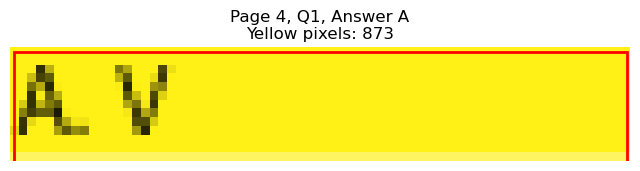

Page 4, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=73.3, y1=127.3
Page 4, Q1, B: Yellow pixels: 68
Page 4, Q1, B: Total non-white pixels: 118
Page 4, Q1, B: Yellow percentage: 57.6%


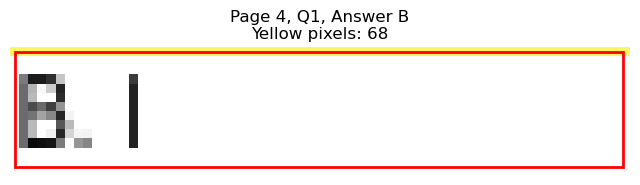

Page 4, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=337.6, y1=114.7
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 84
Page 4, Q1, C: Yellow percentage: 0.0%


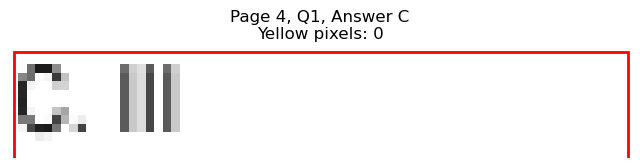

Page 4, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=338.6, y1=127.3
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 82
Page 4, Q1, D: Yellow percentage: 0.0%


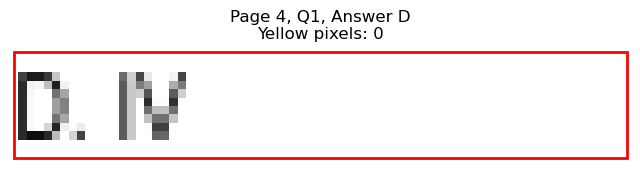


Page 4, Q1 - Selected Answer: A (based on yellow pixel count)
Page 4, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=103.5, y1=177.8
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 234
Page 4, Q2, A: Yellow percentage: 0.0%


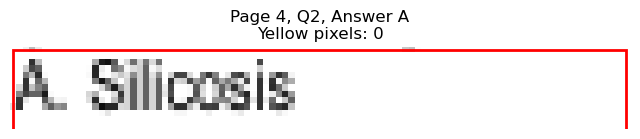

Page 4, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=118.5, y1=190.4
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 314
Page 4, Q2, B: Yellow percentage: 0.0%


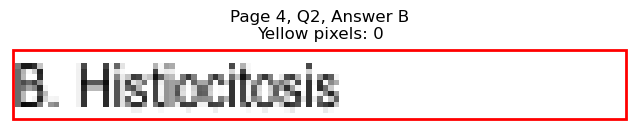

Page 4, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=397.7, y1=177.8
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 529
Page 4, Q2, C: Yellow percentage: 0.0%


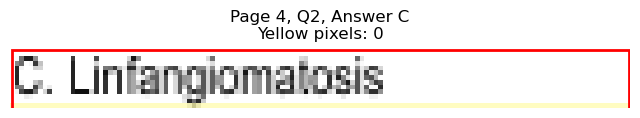

Page 4, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=381.2, y1=190.4
Page 4, Q2, D: Yellow pixels: 1164
Page 4, Q2, D: Total non-white pixels: 1638
Page 4, Q2, D: Yellow percentage: 71.1%


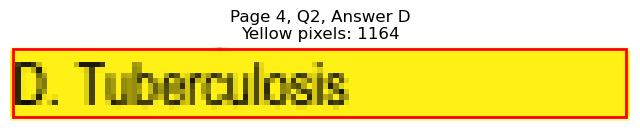


Page 4, Q2 - Selected Answer: D (based on yellow pixel count)
Page 4, Q3 - A: Detected box: x0=56.6, y0=228.2, x1=85.8, y1=240.9
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 132
Page 4, Q3, A: Yellow percentage: 0.0%


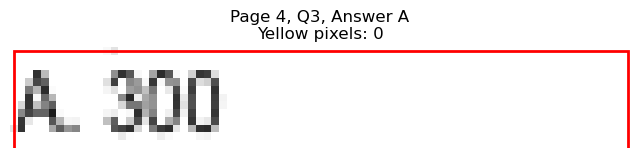

Page 4, Q3 - B: Detected box: x0=56.6, y0=240.8, x1=85.8, y1=253.5
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 124
Page 4, Q3, B: Yellow percentage: 0.0%


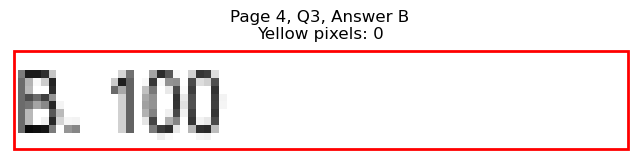

Page 4, Q3 - C: Detected box: x0=315.4, y0=228.2, x1=345.1, y1=240.9
Page 4, Q3, C: Yellow pixels: 967
Page 4, Q3, C: Total non-white pixels: 1053
Page 4, Q3, C: Yellow percentage: 91.8%


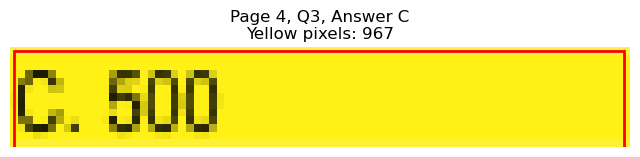

Page 4, Q3 - D: Detected box: x0=315.4, y0=240.8, x1=340.1, y1=253.5
Page 4, Q3, D: Yellow pixels: 76
Page 4, Q3, D: Total non-white pixels: 176
Page 4, Q3, D: Yellow percentage: 43.2%


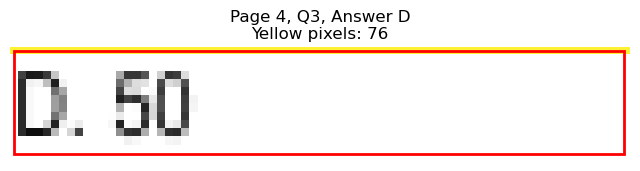


Page 4, Q3 - Selected Answer: C (based on yellow pixel count)
Page 4, Q4 - A: Detected box: x0=56.6, y0=291.4, x1=142.5, y1=304.0
Page 4, Q4, A: Yellow pixels: 137
Page 4, Q4, A: Total non-white pixels: 519
Page 4, Q4, A: Yellow percentage: 26.4%


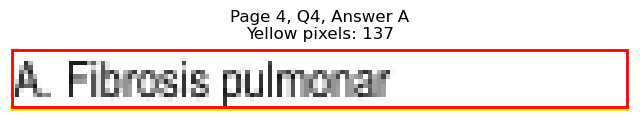

Page 4, Q4 - B: Detected box: x0=56.6, y0=304.0, x1=155.1, y1=316.6
Page 4, Q4, B: Yellow pixels: 1583
Page 4, Q4, B: Total non-white pixels: 1951
Page 4, Q4, B: Yellow percentage: 81.1%


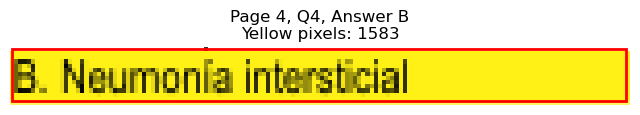

Page 4, Q4 - C: Detected box: x0=315.4, y0=291.4, x1=391.7, y1=304.0
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 364
Page 4, Q4, C: Yellow percentage: 0.0%


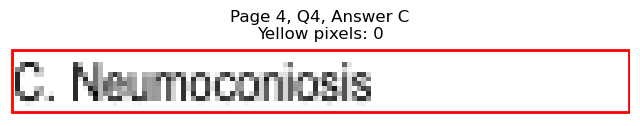

Page 4, Q4 - D: Detected box: x0=315.4, y0=304.0, x1=430.4, y1=316.6
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 553
Page 4, Q4, D: Yellow percentage: 0.0%


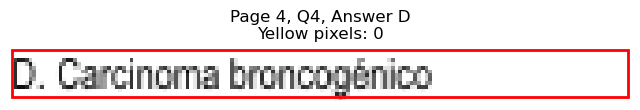


Page 4, Q4 - Selected Answer: B (based on yellow pixel count)
Page 4, Q5 - A: Detected box: x0=56.6, y0=354.5, x1=121.9, y1=367.2
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 303
Page 4, Q5, A: Yellow percentage: 0.0%


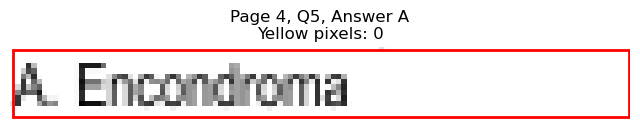

Page 4, Q5 - B: Detected box: x0=56.6, y0=367.1, x1=135.0, y1=379.8
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 366
Page 4, Q5, B: Yellow percentage: 0.0%


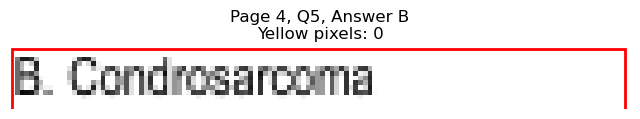

Page 4, Q5 - C: Detected box: x0=315.4, y0=354.5, x1=396.3, y1=367.2
Page 4, Q5, C: Yellow pixels: 1397
Page 4, Q5, C: Total non-white pixels: 1848
Page 4, Q5, C: Yellow percentage: 75.6%


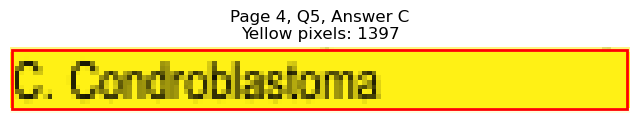

Page 4, Q5 - D: Detected box: x0=315.4, y0=367.1, x1=394.3, y1=379.8
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 501
Page 4, Q5, D: Yellow percentage: 0.0%


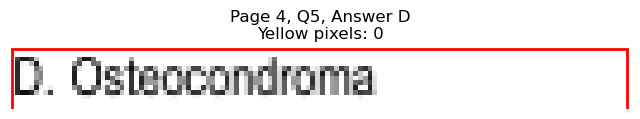


Page 4, Q5 - Selected Answer: C (based on yellow pixel count)
Page 4, Q6 - A: Detected box: x0=56.6, y0=442.8, x1=114.4, y1=455.5
Page 4, Q6, A: Yellow pixels: 109
Page 4, Q6, A: Total non-white pixels: 380
Page 4, Q6, A: Yellow percentage: 28.7%


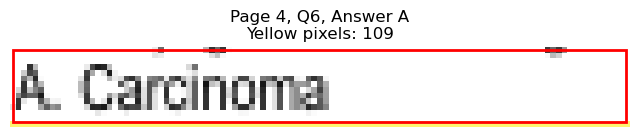

Page 4, Q6 - B: Detected box: x0=56.6, y0=455.5, x1=109.5, y1=468.1
Page 4, Q6, B: Yellow pixels: 1154
Page 4, Q6, B: Total non-white pixels: 1456
Page 4, Q6, B: Yellow percentage: 79.3%


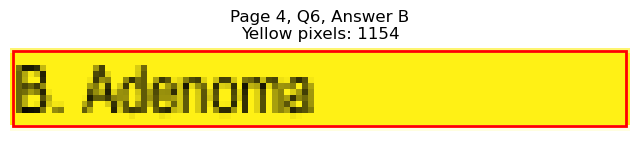

Page 4, Q6 - C: Detected box: x0=315.4, y0=442.8, x1=364.6, y1=455.5
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 216
Page 4, Q6, C: Yellow percentage: 0.0%


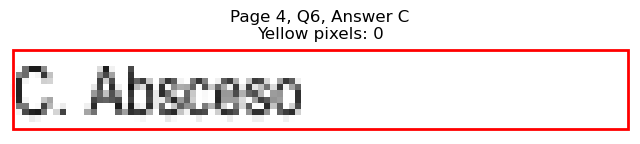

Page 4, Q6 - D: Detected box: x0=315.4, y0=455.5, x1=373.1, y1=468.1
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 288
Page 4, Q6, D: Yellow percentage: 0.0%


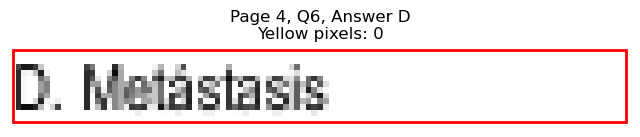


Page 4, Q6 - Selected Answer: B (based on yellow pixel count)
Page 4, Q7 - A: Detected box: x0=56.6, y0=506.0, x1=154.1, y1=518.6
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 504
Page 4, Q7, A: Yellow percentage: 0.0%


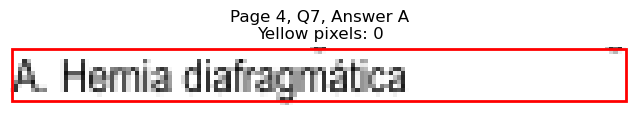

Page 4, Q7 - B: Detected box: x0=56.6, y0=518.6, x1=119.9, y1=531.2
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 316
Page 4, Q7, B: Yellow percentage: 0.0%


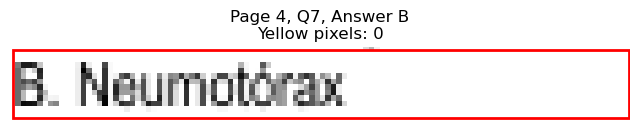

Page 4, Q7 - C: Detected box: x0=315.4, y0=506.0, x1=446.9, y1=518.6
Page 4, Q7, C: Yellow pixels: 1866
Page 4, Q7, C: Total non-white pixels: 2548
Page 4, Q7, C: Yellow percentage: 73.2%


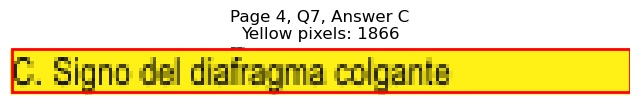

Page 4, Q7 - D: Detected box: x0=315.4, y0=518.6, x1=447.4, y1=531.2
Page 4, Q7, D: Yellow pixels: 178
Page 4, Q7, D: Total non-white pixels: 863
Page 4, Q7, D: Yellow percentage: 20.6%


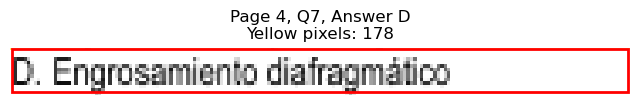


Page 4, Q7 - Selected Answer: C (based on yellow pixel count)
Page 4, Q8 - A: Detected box: x0=56.6, y0=581.7, x1=102.4, y1=594.3
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 222
Page 4, Q8, A: Yellow percentage: 0.0%


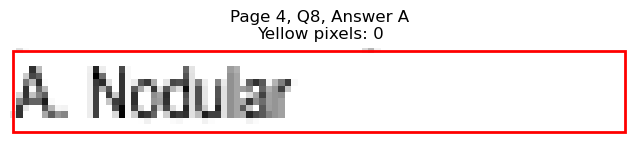

Page 4, Q8 - B: Detected box: x0=56.6, y0=594.3, x1=109.9, y1=606.9
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 224
Page 4, Q8, B: Yellow percentage: 0.0%


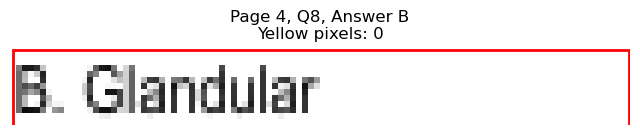

Page 4, Q8 - C: Detected box: x0=315.4, y0=581.7, x1=371.2, y1=594.3
Page 4, Q8, C: Yellow pixels: 1068
Page 4, Q8, C: Total non-white pixels: 1498
Page 4, Q8, C: Yellow percentage: 71.3%


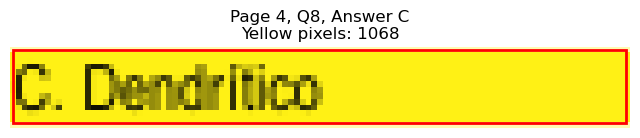

Page 4, Q8 - D: Detected box: x0=315.4, y0=594.3, x1=362.7, y1=606.9
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 296
Page 4, Q8, D: Yellow percentage: 0.0%


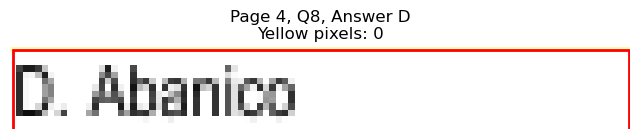


Page 4, Q8 - Selected Answer: C (based on yellow pixel count)
Page 4, Q9 - A: Detected box: x0=56.6, y0=644.8, x1=98.9, y1=657.5
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 172
Page 4, Q9, A: Yellow percentage: 0.0%


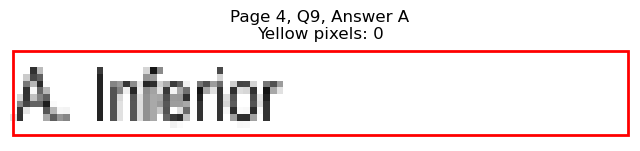

Page 4, Q9 - B: Detected box: x0=56.6, y0=657.4, x1=95.4, y1=670.1
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 198
Page 4, Q9, B: Yellow percentage: 0.0%


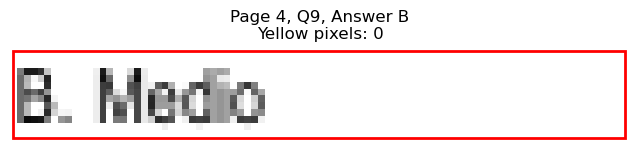

Page 4, Q9 - C: Detected box: x0=315.4, y0=644.8, x1=359.7, y1=657.5
Page 4, Q9, C: Yellow pixels: 95
Page 4, Q9, C: Total non-white pixels: 289
Page 4, Q9, C: Yellow percentage: 32.9%


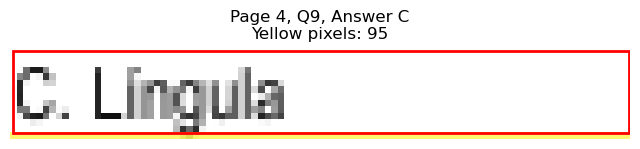

Page 4, Q9 - D: Detected box: x0=315.4, y0=657.4, x1=364.1, y1=670.1
Page 4, Q9, D: Yellow pixels: 1141
Page 4, Q9, D: Total non-white pixels: 1400
Page 4, Q9, D: Yellow percentage: 81.5%


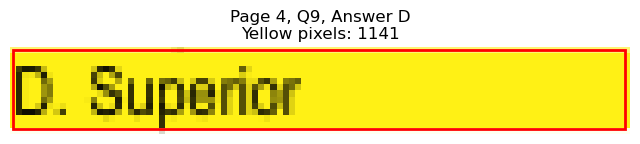


Page 4, Q9 - Selected Answer: D (based on yellow pixel count)
Page 4, Q10 - A: Detected box: x0=56.6, y0=720.6, x1=177.1, y1=733.2
Page 4, Q10, A: Yellow pixels: 172
Page 4, Q10, A: Total non-white pixels: 751
Page 4, Q10, A: Yellow percentage: 22.9%


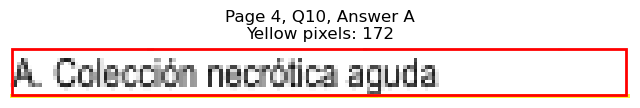

Page 4, Q10 - B: Detected box: x0=56.6, y0=733.2, x1=153.0, y1=745.8
Page 4, Q10, B: Yellow pixels: 1575
Page 4, Q10, B: Total non-white pixels: 1924
Page 4, Q10, B: Yellow percentage: 81.9%


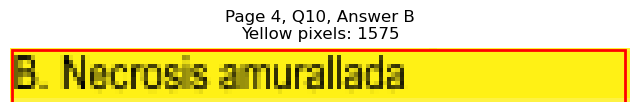

Page 4, Q10 - C: Detected box: x0=315.4, y0=720.6, x1=384.8, y1=733.2
Page 4, Q10, C: Yellow pixels: 0
Page 4, Q10, C: Total non-white pixels: 348
Page 4, Q10, C: Yellow percentage: 0.0%


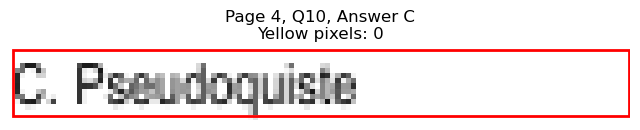

Page 4, Q10 - D: Detected box: x0=315.4, y0=733.2, x1=362.2, y1=745.8
Page 4, Q10, D: Yellow pixels: 0
Page 4, Q10, D: Total non-white pixels: 222
Page 4, Q10, D: Yellow percentage: 0.0%


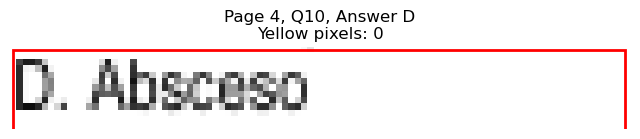


Page 4, Q10 - Selected Answer: B (based on yellow pixel count)

Page 5: Found 11 questions
Page 5, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=103.9, y1=127.3
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 210
Page 5, Q1, A: Yellow percentage: 0.0%


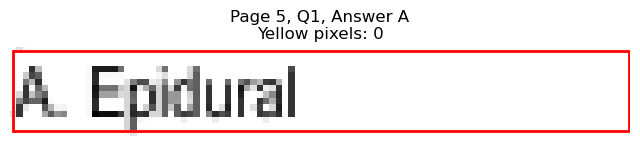

Page 5, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=106.9, y1=139.9
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 226
Page 5, Q1, B: Yellow percentage: 0.0%


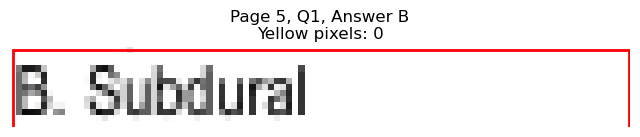

Page 5, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=373.1, y1=127.3
Page 5, Q1, C: Yellow pixels: 109
Page 5, Q1, C: Total non-white pixels: 374
Page 5, Q1, C: Yellow percentage: 29.1%


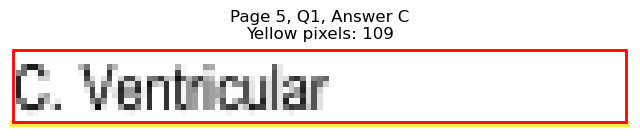

Page 5, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=380.7, y1=139.9
Page 5, Q1, D: Yellow pixels: 1243
Page 5, Q1, D: Total non-white pixels: 1508
Page 5, Q1, D: Yellow percentage: 82.4%


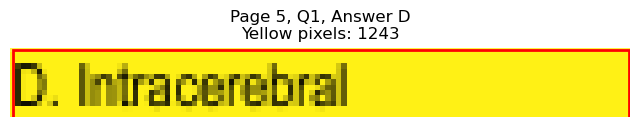


Page 5, Q1 - Selected Answer: D (based on yellow pixel count)
Page 5, Q2 - A: Detected box: x0=56.6, y0=190.3, x1=150.5, y1=203.0
Page 5, Q2, A: Yellow pixels: 1508
Page 5, Q2, A: Total non-white pixels: 1885
Page 5, Q2, A: Yellow percentage: 80.0%


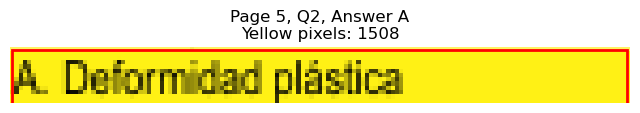

Page 5, Q2 - B: Detected box: x0=56.6, y0=202.9, x1=115.5, y1=215.6
Page 5, Q2, B: Yellow pixels: 109
Page 5, Q2, B: Total non-white pixels: 381
Page 5, Q2, B: Yellow percentage: 28.6%


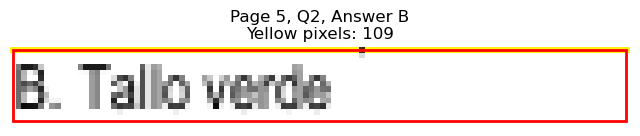

Page 5, Q2 - C: Detected box: x0=315.4, y0=190.3, x1=369.2, y1=203.0
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 226
Page 5, Q2, C: Yellow percentage: 0.0%


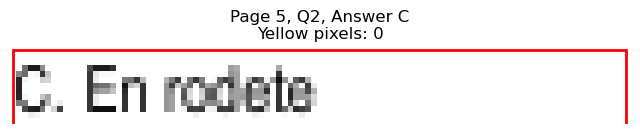

Page 5, Q2 - D: Detected box: x0=315.4, y0=202.9, x1=374.2, y1=215.6
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 308
Page 5, Q2, D: Yellow percentage: 0.0%


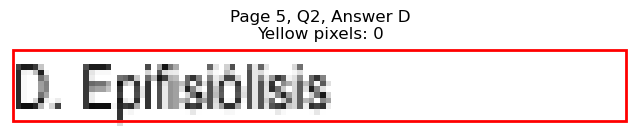


Page 5, Q2 - Selected Answer: A (based on yellow pixel count)
Page 5, Q3 - A: Detected box: x0=56.6, y0=253.4, x1=88.3, y1=266.1
Page 5, Q3, A: Yellow pixels: 991
Page 5, Q3, A: Total non-white pixels: 1162
Page 5, Q3, A: Yellow percentage: 85.3%


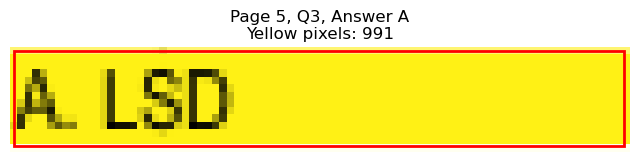

Page 5, Q3 - B: Detected box: x0=56.6, y0=266.0, x1=83.3, y1=278.7
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 193
Page 5, Q3, B: Yellow percentage: 0.0%


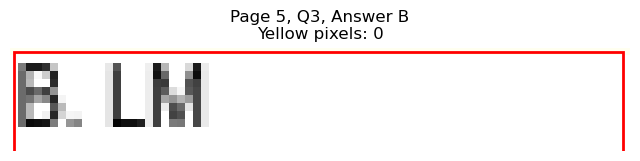

Page 5, Q3 - C: Detected box: x0=315.4, y0=253.4, x1=344.1, y1=266.1
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 100
Page 5, Q3, C: Yellow percentage: 0.0%


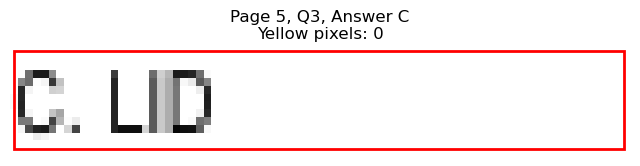

Page 5, Q3 - D: Detected box: x0=315.4, y0=266.0, x1=343.6, y1=278.7
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 103
Page 5, Q3, D: Yellow percentage: 0.0%


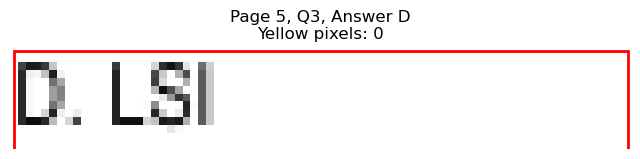


Page 5, Q3 - Selected Answer: A (based on yellow pixel count)
Page 5, Q4 - A: Detected box: x0=56.6, y0=304.0, x1=105.4, y1=316.6
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 203
Page 5, Q4, A: Yellow percentage: 0.0%


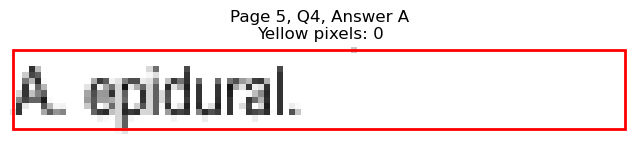

Page 5, Q4 - B: Detected box: x0=56.6, y0=316.6, x1=107.9, y1=329.2
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 247
Page 5, Q4, B: Yellow percentage: 0.0%


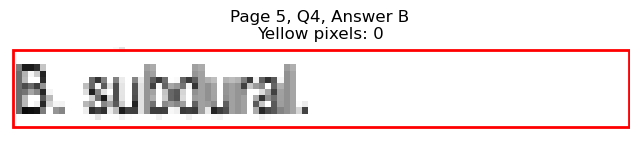

Page 5, Q4 - C: Detected box: x0=315.4, y0=304.0, x1=382.3, y1=316.6
Page 5, Q4, C: Yellow pixels: 1324
Page 5, Q4, C: Total non-white pixels: 1534
Page 5, Q4, C: Yellow percentage: 86.3%


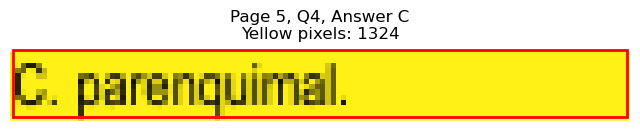

Page 5, Q4 - D: Detected box: x0=315.4, y0=316.6, x1=374.2, y1=329.2
Page 5, Q4, D: Yellow pixels: 110
Page 5, Q4, D: Total non-white pixels: 373
Page 5, Q4, D: Yellow percentage: 29.5%


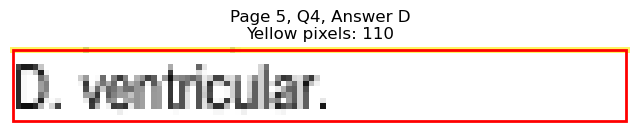


Page 5, Q4 - Selected Answer: C (based on yellow pixel count)
Page 5, Q5 - A: Detected box: x0=56.6, y0=354.5, x1=112.9, y1=367.2
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 254
Page 5, Q5, A: Yellow percentage: 0.0%


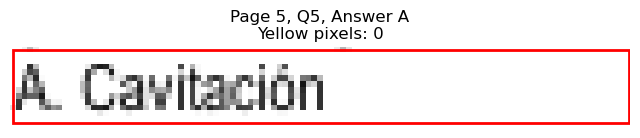

Page 5, Q5 - B: Detected box: x0=56.6, y0=367.1, x1=177.6, y1=379.8
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 611
Page 5, Q5, B: Yellow percentage: 0.0%


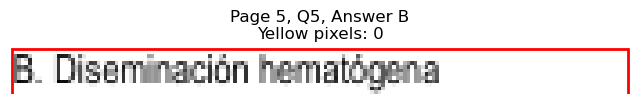

Page 5, Q5 - C: Detected box: x0=315.4, y0=354.5, x1=394.3, y1=367.2
Page 5, Q5, C: Yellow pixels: 130
Page 5, Q5, C: Total non-white pixels: 509
Page 5, Q5, C: Yellow percentage: 25.5%


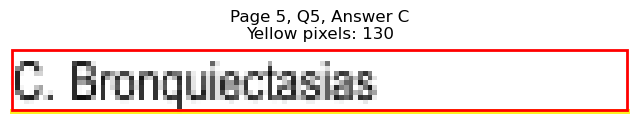

Page 5, Q5 - D: Detected box: x0=315.4, y0=367.1, x1=408.4, y1=379.8
Page 5, Q5, D: Yellow pixels: 1532
Page 5, Q5, D: Total non-white pixels: 1872
Page 5, Q5, D: Yellow percentage: 81.8%


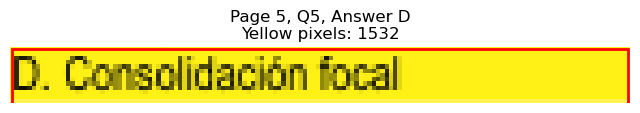


Page 5, Q5 - Selected Answer: D (based on yellow pixel count)
Page 5, Q6 - A: Detected box: x0=56.6, y0=404.9, x1=172.1, y1=417.6
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 566
Page 5, Q6, A: Yellow percentage: 0.0%


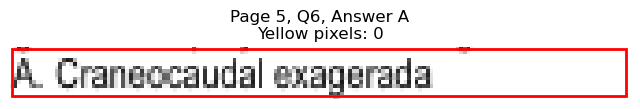

Page 5, Q6 - B: Detected box: x0=56.6, y0=417.6, x1=123.0, y1=430.3
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 301
Page 5, Q6, B: Yellow percentage: 0.0%


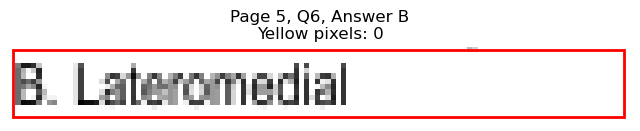

Page 5, Q6 - C: Detected box: x0=315.4, y0=404.9, x1=374.2, y1=417.6
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 290
Page 5, Q6, C: Yellow percentage: 0.0%


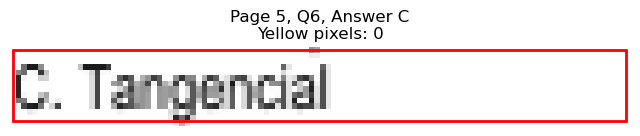

Page 5, Q6 - D: Detected box: x0=315.4, y0=417.6, x1=364.6, y1=430.3
Page 5, Q6, D: Yellow pixels: 1013
Page 5, Q6, D: Total non-white pixels: 1400
Page 5, Q6, D: Yellow percentage: 72.4%


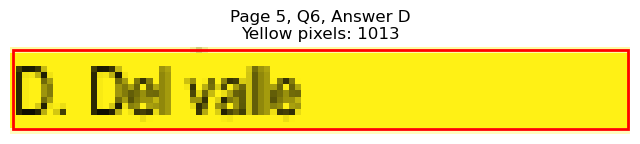


Page 5, Q6 - Selected Answer: D (based on yellow pixel count)
Page 5, Q7 - A: Detected box: x0=56.6, y0=455.5, x1=159.1, y1=468.1
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 479
Page 5, Q7, A: Yellow percentage: 0.0%


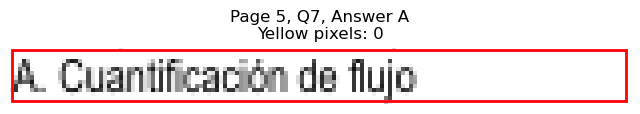

Page 5, Q7 - B: Detected box: x0=56.6, y0=468.1, x1=124.5, y1=480.7
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 327
Page 5, Q7, B: Yellow percentage: 0.0%


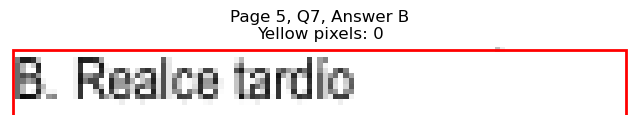

Page 5, Q7 - C: Detected box: x0=315.4, y0=455.5, x1=410.3, y1=468.1
Page 5, Q7, C: Yellow pixels: 1563
Page 5, Q7, C: Total non-white pixels: 2044
Page 5, Q7, C: Yellow percentage: 76.5%


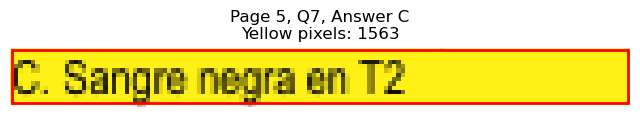

Page 5, Q7 - D: Detected box: x0=315.4, y0=468.1, x1=410.3, y1=480.7
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 567
Page 5, Q7, D: Yellow percentage: 0.0%


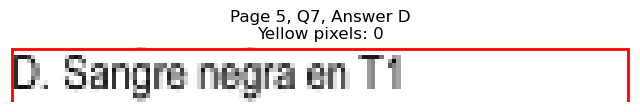


Page 5, Q7 - Selected Answer: C (based on yellow pixel count)
Page 5, Q8 - A: Detected box: x0=56.6, y0=518.6, x1=170.7, y1=531.2
Page 5, Q8, A: Yellow pixels: 1710
Page 5, Q8, A: Total non-white pixels: 2310
Page 5, Q8, A: Yellow percentage: 74.0%


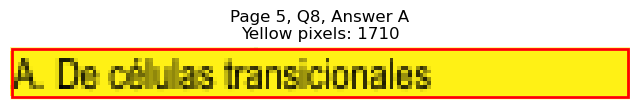

Page 5, Q8 - B: Detected box: x0=56.6, y0=531.2, x1=112.9, y1=543.8
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 368
Page 5, Q8, B: Yellow percentage: 0.0%


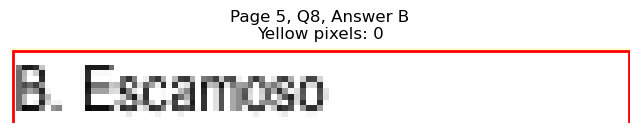

Page 5, Q8 - C: Detected box: x0=315.4, y0=518.6, x1=374.2, y1=531.2
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 269
Page 5, Q8, C: Yellow percentage: 0.0%


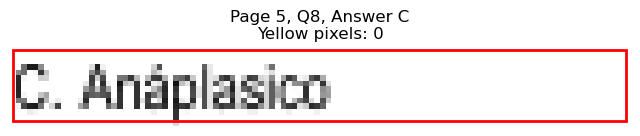

Page 5, Q8 - D: Detected box: x0=315.4, y0=531.2, x1=404.2, y1=543.8
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 439
Page 5, Q8, D: Yellow percentage: 0.0%


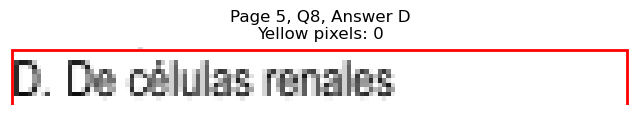


Page 5, Q8 - Selected Answer: A (based on yellow pixel count)
Page 5, Q9 - A: Detected box: x0=56.6, y0=581.7, x1=189.6, y1=594.3
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 669
Page 5, Q9, A: Yellow percentage: 0.0%


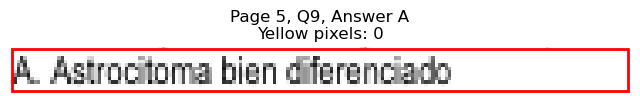

Page 5, Q9 - B: Detected box: x0=56.6, y0=594.3, x1=164.1, y1=606.9
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 529
Page 5, Q9, B: Yellow percentage: 0.0%


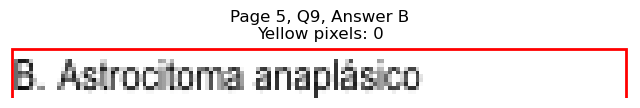

Page 5, Q9 - C: Detected box: x0=315.4, y0=581.7, x1=442.9, y1=594.3
Page 5, Q9, C: Yellow pixels: 178
Page 5, Q9, C: Total non-white pixels: 811
Page 5, Q9, C: Yellow percentage: 21.9%


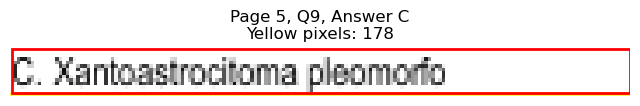

Page 5, Q9 - D: Detected box: x0=315.4, y0=594.3, x1=443.3, y1=606.9
Page 5, Q9, D: Yellow pixels: 1848
Page 5, Q9, D: Total non-white pixels: 2327
Page 5, Q9, D: Yellow percentage: 79.4%


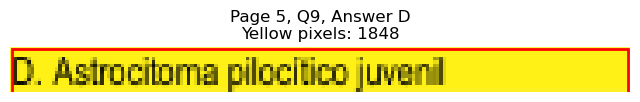


Page 5, Q9 - Selected Answer: D (based on yellow pixel count)
Page 5, Q10 - A: Detected box: x0=56.6, y0=632.2, x1=121.5, y1=644.9
Page 5, Q10, A: Yellow pixels: 0
Page 5, Q10, A: Total non-white pixels: 293
Page 5, Q10, A: Yellow percentage: 0.0%


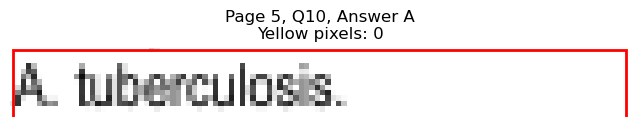

Page 5, Q10 - B: Detected box: x0=56.6, y0=644.8, x1=132.5, y1=657.5
Page 5, Q10, B: Yellow pixels: 0
Page 5, Q10, B: Total non-white pixels: 379
Page 5, Q10, B: Yellow percentage: 0.0%


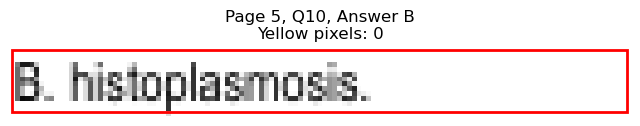

Page 5, Q10 - C: Detected box: x0=315.4, y0=632.2, x1=428.8, y1=644.9
Page 5, Q10, C: Yellow pixels: 0
Page 5, Q10, C: Total non-white pixels: 703
Page 5, Q10, C: Yellow percentage: 0.0%


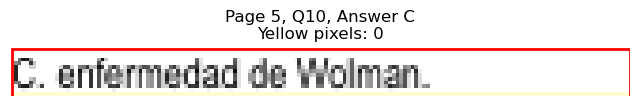

Page 5, Q10 - D: Detected box: x0=315.4, y0=644.8, x1=378.2, y1=657.5
Page 5, Q10, D: Yellow pixels: 1254
Page 5, Q10, D: Total non-white pixels: 1596
Page 5, Q10, D: Yellow percentage: 78.6%


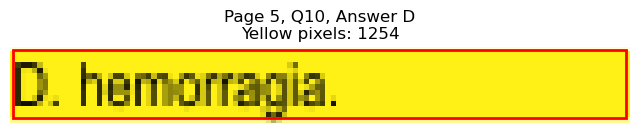


Page 5, Q10 - Selected Answer: D (based on yellow pixel count)
Page 5, Q11 - A: Detected box: x0=56.6, y0=695.4, x1=167.1, y1=708.0
Page 5, Q11, A: Yellow pixels: 162
Page 5, Q11, A: Total non-white pixels: 849
Page 5, Q11, A: Yellow percentage: 19.1%


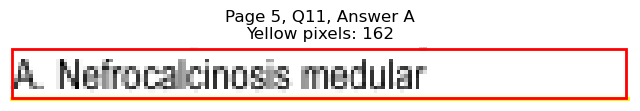

Page 5, Q11 - B: Detected box: x0=56.6, y0=708.0, x1=163.1, y1=720.6
Page 5, Q11, B: Yellow pixels: 1638
Page 5, Q11, B: Total non-white pixels: 2212
Page 5, Q11, B: Yellow percentage: 74.1%


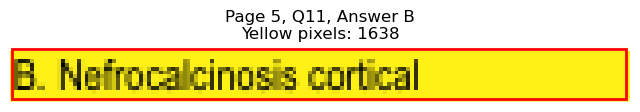

Page 5, Q11 - C: Detected box: x0=315.4, y0=695.4, x1=387.2, y1=708.0
Page 5, Q11, C: Yellow pixels: 0
Page 5, Q11, C: Total non-white pixels: 363
Page 5, Q11, C: Yellow percentage: 0.0%


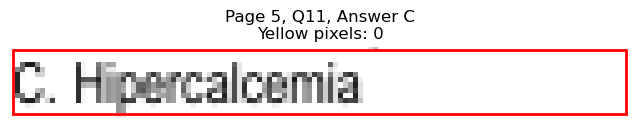

Page 5, Q11 - D: Detected box: x0=315.4, y0=708.0, x1=414.8, y1=720.6
Page 5, Q11, D: Yellow pixels: 0
Page 5, Q11, D: Total non-white pixels: 512
Page 5, Q11, D: Yellow percentage: 0.0%


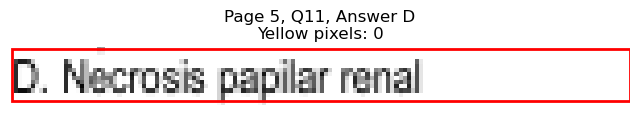


Page 5, Q11 - Selected Answer: B (based on yellow pixel count)

Page 6: Found 10 questions
Page 6, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=117.5, y1=114.7
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 297
Page 6, Q1, A: Yellow percentage: 0.0%


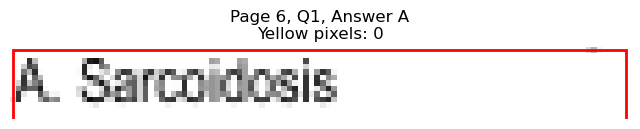

Page 6, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=166.6, y1=127.3
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 553
Page 6, Q1, B: Yellow percentage: 0.0%


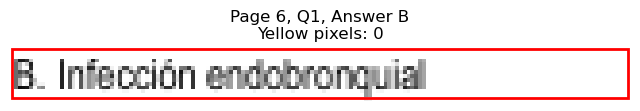

Page 6, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=407.2, y1=114.7
Page 6, Q1, C: Yellow pixels: 1532
Page 6, Q1, C: Total non-white pixels: 1859
Page 6, Q1, C: Yellow percentage: 82.4%


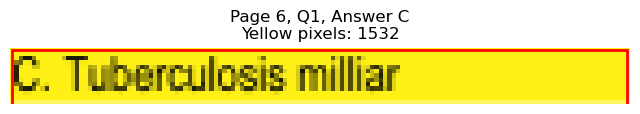

Page 6, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=434.3, y1=127.3
Page 6, Q1, D: Yellow pixels: 170
Page 6, Q1, D: Total non-white pixels: 759
Page 6, Q1, D: Yellow percentage: 22.4%


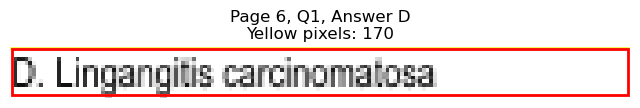


Page 6, Q1 - Selected Answer: C (based on yellow pixel count)
Page 6, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=159.6, y1=177.8
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 506
Page 6, Q2, A: Yellow percentage: 0.0%


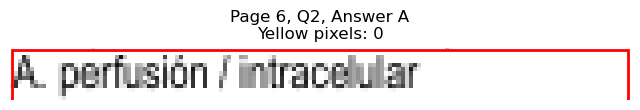

Page 6, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=158.5, y1=190.4
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 478
Page 6, Q2, B: Yellow percentage: 0.0%


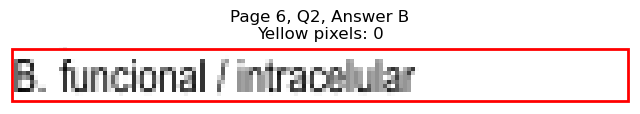

Page 6, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=442.9, y1=177.8
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 793
Page 6, Q2, C: Yellow percentage: 0.0%


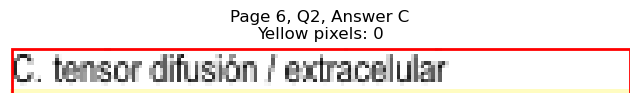

Page 6, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=415.3, y1=190.4
Page 6, Q2, D: Yellow pixels: 1449
Page 6, Q2, D: Total non-white pixels: 2114
Page 6, Q2, D: Yellow percentage: 68.5%


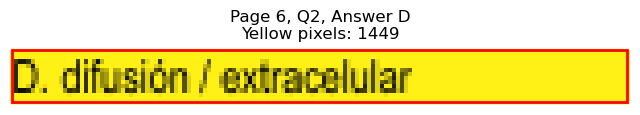


Page 6, Q2 - Selected Answer: D (based on yellow pixel count)
Page 6, Q3 - A: Detected box: x0=56.6, y0=240.8, x1=141.0, y1=253.5
Page 6, Q3, A: Yellow pixels: 136
Page 6, Q3, A: Total non-white pixels: 536
Page 6, Q3, A: Yellow percentage: 25.4%


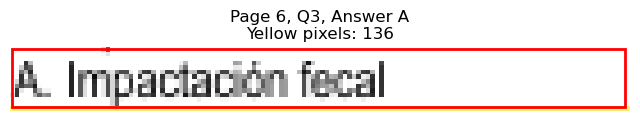

Page 6, Q3 - B: Detected box: x0=56.6, y0=253.4, x1=106.9, y1=266.1
Page 6, Q3, B: Yellow pixels: 1144
Page 6, Q3, B: Total non-white pixels: 1414
Page 6, Q3, B: Yellow percentage: 80.9%


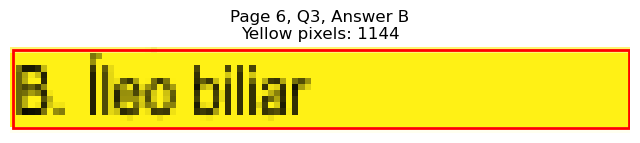

Page 6, Q3 - C: Detected box: x0=315.4, y0=240.8, x1=380.2, y1=253.5
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 296
Page 6, Q3, C: Yellow percentage: 0.0%


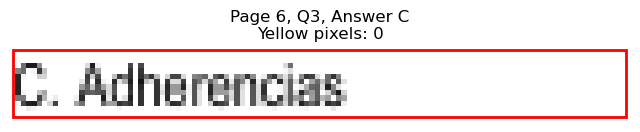

Page 6, Q3 - D: Detected box: x0=315.4, y0=253.4, x1=413.8, y1=266.1
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 498
Page 6, Q3, D: Yellow percentage: 0.0%


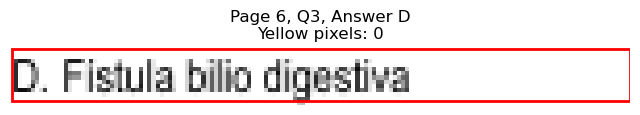


Page 6, Q3 - Selected Answer: B (based on yellow pixel count)
Page 6, Q4 - A: Detected box: x0=56.6, y0=291.4, x1=200.8, y1=304.0
Page 6, Q4, A: Yellow pixels: 2011
Page 6, Q4, A: Total non-white pixels: 2730
Page 6, Q4, A: Yellow percentage: 73.7%


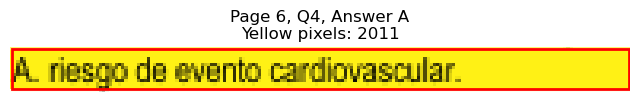

Page 6, Q4 - B: Detected box: x0=56.6, y0=304.0, x1=204.6, y1=316.6
Page 6, Q4, B: Yellow pixels: 195
Page 6, Q4, B: Total non-white pixels: 1095
Page 6, Q4, B: Yellow percentage: 17.8%


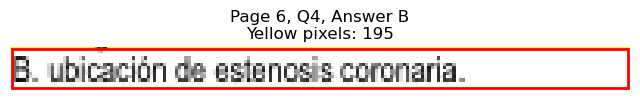

Page 6, Q4 - C: Detected box: x0=315.4, y0=291.4, x1=449.0, y1=304.0
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 625
Page 6, Q4, C: Yellow percentage: 0.0%


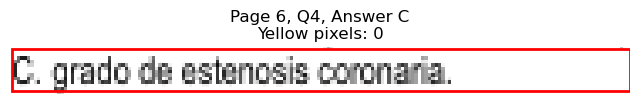

Page 6, Q4 - D: Detected box: x0=315.4, y0=304.0, x1=379.1, y1=316.6
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 320
Page 6, Q4, D: Yellow percentage: 0.0%


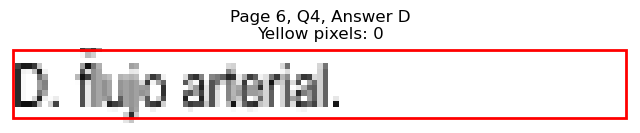


Page 6, Q4 - Selected Answer: A (based on yellow pixel count)
Page 6, Q5 - A: Detected box: x0=56.6, y0=367.1, x1=110.9, y1=379.8
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 256
Page 6, Q5, A: Yellow percentage: 0.0%


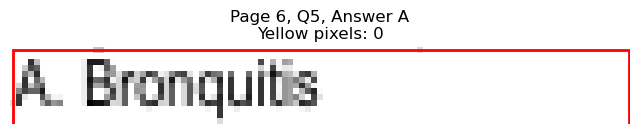

Page 6, Q5 - B: Detected box: x0=56.6, y0=379.7, x1=143.5, y1=392.4
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 410
Page 6, Q5, B: Yellow percentage: 0.0%


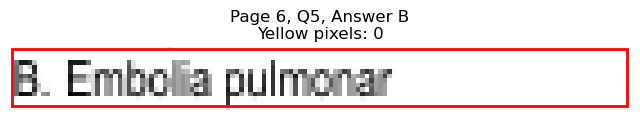

Page 6, Q5 - C: Detected box: x0=315.4, y0=367.1, x1=401.8, y1=379.8
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 554
Page 6, Q5, C: Yellow percentage: 0.0%


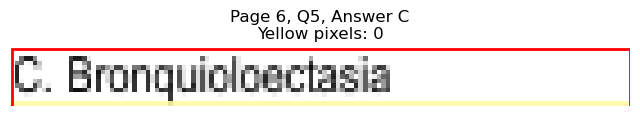

Page 6, Q5 - D: Detected box: x0=315.4, y0=379.7, x1=394.3, y1=392.4
Page 6, Q5, D: Yellow pixels: 1279
Page 6, Q5, D: Total non-white pixels: 1820
Page 6, Q5, D: Yellow percentage: 70.3%


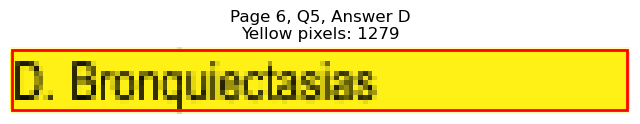


Page 6, Q5 - Selected Answer: D (based on yellow pixel count)
Page 6, Q6 - A: Detected box: x0=56.6, y0=430.2, x1=172.1, y1=442.9
Page 6, Q6, A: Yellow pixels: 1743
Page 6, Q6, A: Total non-white pixels: 2171
Page 6, Q6, A: Yellow percentage: 80.3%


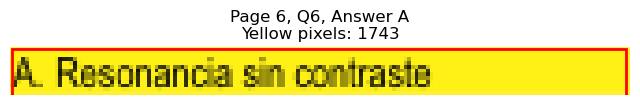

Page 6, Q6 - B: Detected box: x0=56.6, y0=442.8, x1=175.6, y1=455.5
Page 6, Q6, B: Yellow pixels: 170
Page 6, Q6, B: Total non-white pixels: 741
Page 6, Q6, B: Yellow percentage: 22.9%


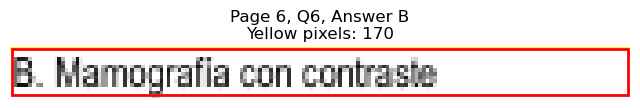

Page 6, Q6 - C: Detected box: x0=315.4, y0=430.2, x1=434.3, y1=442.9
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 555
Page 6, Q6, C: Yellow percentage: 0.0%


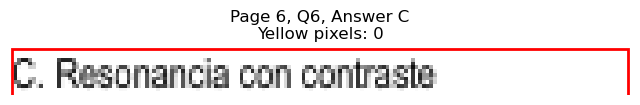

Page 6, Q6 - D: Detected box: x0=315.4, y0=442.8, x1=431.8, y1=455.5
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 578
Page 6, Q6, D: Yellow percentage: 0.0%


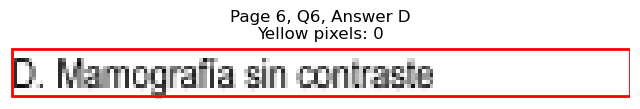


Page 6, Q6 - Selected Answer: A (based on yellow pixel count)
Page 6, Q7 - A: Detected box: x0=56.6, y0=506.0, x1=143.5, y1=518.6
Page 6, Q7, A: Yellow pixels: 1456
Page 6, Q7, A: Total non-white pixels: 1932
Page 6, Q7, A: Yellow percentage: 75.4%


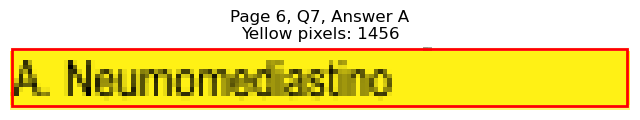

Page 6, Q7 - B: Detected box: x0=56.6, y0=518.6, x1=120.5, y1=531.2
Page 6, Q7, B: Yellow pixels: 115
Page 6, Q7, B: Total non-white pixels: 468
Page 6, Q7, B: Yellow percentage: 24.6%


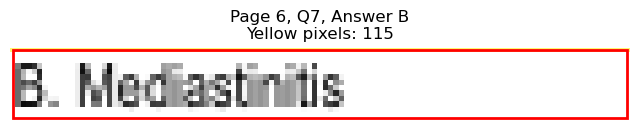

Page 6, Q7 - C: Detected box: x0=315.4, y0=506.0, x1=379.1, y1=518.6
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 308
Page 6, Q7, C: Yellow percentage: 0.0%


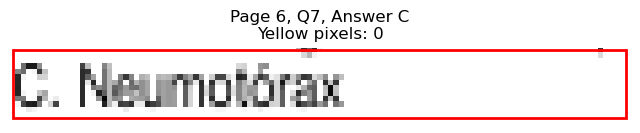

Page 6, Q7 - D: Detected box: x0=315.4, y0=518.6, x1=398.2, y1=531.2
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 407
Page 6, Q7, D: Yellow percentage: 0.0%


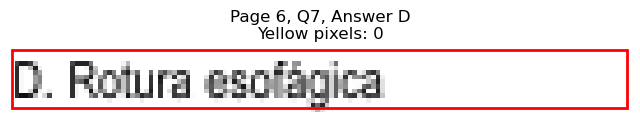


Page 6, Q7 - Selected Answer: A (based on yellow pixel count)
Page 6, Q8 - A: Detected box: x0=56.6, y0=581.7, x1=132.5, y1=594.3
Page 6, Q8, A: Yellow pixels: 1249
Page 6, Q8, A: Total non-white pixels: 1778
Page 6, Q8, A: Yellow percentage: 70.2%


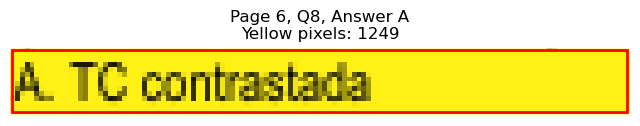

Page 6, Q8 - B: Detected box: x0=56.6, y0=594.3, x1=104.4, y1=606.9
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 313
Page 6, Q8, B: Yellow percentage: 0.0%


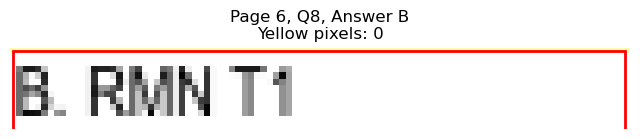

Page 6, Q8 - C: Detected box: x0=315.4, y0=581.7, x1=363.7, y1=594.3
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 204
Page 6, Q8, C: Yellow percentage: 0.0%


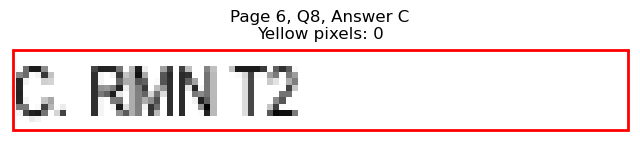

Page 6, Q8 - D: Detected box: x0=315.4, y0=594.3, x1=362.1, y1=606.9
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 196
Page 6, Q8, D: Yellow percentage: 0.0%


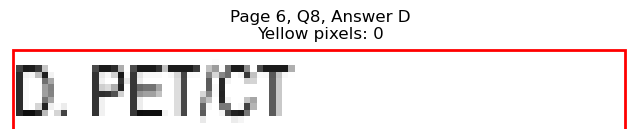


Page 6, Q8 - Selected Answer: A (based on yellow pixel count)
Page 6, Q9 - A: Detected box: x0=56.6, y0=644.8, x1=152.1, y1=657.5
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 451
Page 6, Q9, A: Yellow percentage: 0.0%


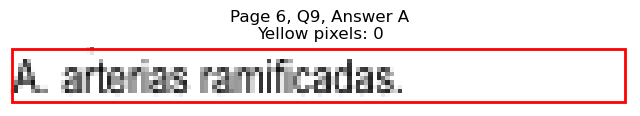

Page 6, Q9 - B: Detected box: x0=56.6, y0=657.4, x1=153.0, y1=670.1
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 470
Page 6, Q9, B: Yellow percentage: 0.0%


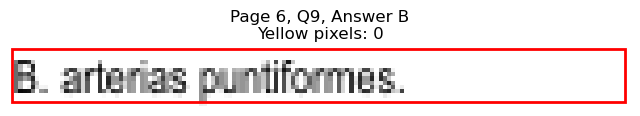

Page 6, Q9 - C: Detected box: x0=315.4, y0=644.8, x1=427.4, y1=657.5
Page 6, Q9, C: Yellow pixels: 1713
Page 6, Q9, C: Total non-white pixels: 2282
Page 6, Q9, C: Yellow percentage: 75.1%


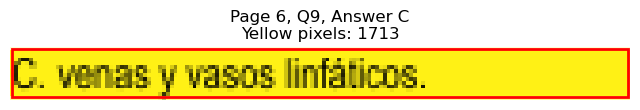

Page 6, Q9 - D: Detected box: x0=315.4, y0=657.4, x1=424.4, y1=670.1
Page 6, Q9, D: Yellow pixels: 159
Page 6, Q9, D: Total non-white pixels: 696
Page 6, Q9, D: Yellow percentage: 22.8%


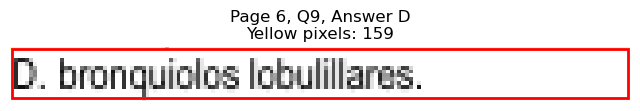


Page 6, Q9 - Selected Answer: C (based on yellow pixel count)
Page 6, Q10 - A: Detected box: x0=56.6, y0=733.2, x1=138.0, y1=745.8
Page 6, Q10, A: Yellow pixels: 0
Page 6, Q10, A: Total non-white pixels: 386
Page 6, Q10, A: Yellow percentage: 0.0%


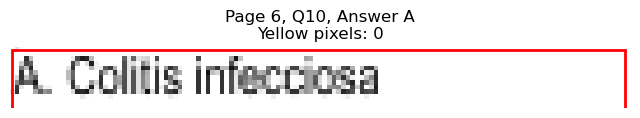

Page 6, Q10 - B: Detected box: x0=56.6, y0=745.8, x1=131.1, y1=758.4
Page 6, Q10, B: Yellow pixels: 0
Page 6, Q10, B: Total non-white pixels: 341
Page 6, Q10, B: Yellow percentage: 0.0%


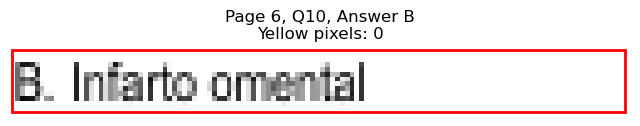

Page 6, Q10 - C: Detected box: x0=315.4, y0=733.2, x1=353.1, y1=745.8
Page 6, Q10, C: Yellow pixels: 1025
Page 6, Q10, C: Total non-white pixels: 1157
Page 6, Q10, C: Yellow percentage: 88.6%


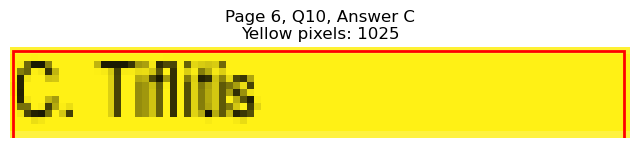

Page 6, Q10 - D: Detected box: x0=315.4, y0=745.8, x1=394.3, y1=758.4
Page 6, Q10, D: Yellow pixels: 130
Page 6, Q10, D: Total non-white pixels: 506
Page 6, Q10, D: Yellow percentage: 25.7%


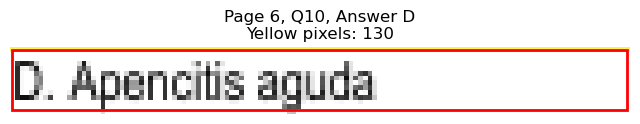


Page 6, Q10 - Selected Answer: C (based on yellow pixel count)

Page 7: Found 10 questions
Page 7, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=114.5, y1=127.3
Page 7, Q1, A: Yellow pixels: 109
Page 7, Q1, A: Total non-white pixels: 363
Page 7, Q1, A: Yellow percentage: 30.0%


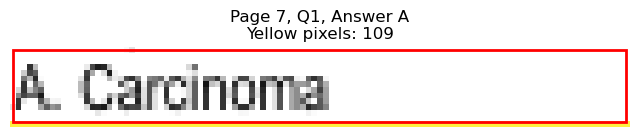

Page 7, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=129.5, y1=139.9
Page 7, Q1, B: Yellow pixels: 1324
Page 7, Q1, B: Total non-white pixels: 1612
Page 7, Q1, B: Yellow percentage: 82.1%


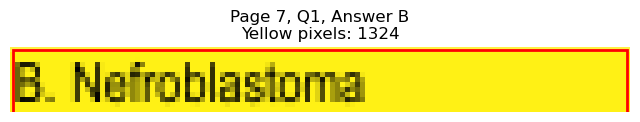

Page 7, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=381.7, y1=127.3
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 281
Page 7, Q1, C: Yellow percentage: 0.0%


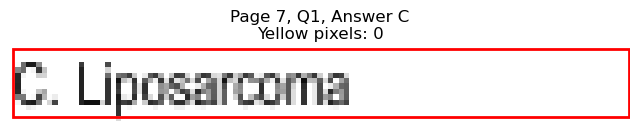

Page 7, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=391.3, y1=139.9
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 383
Page 7, Q1, D: Yellow percentage: 0.0%


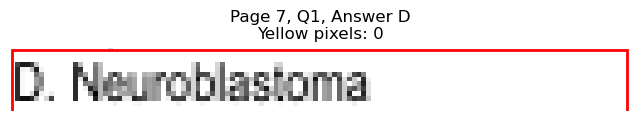


Page 7, Q1 - Selected Answer: B (based on yellow pixel count)
Page 7, Q2 - A: Detected box: x0=56.6, y0=202.9, x1=100.9, y1=215.6
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 200
Page 7, Q2, A: Yellow percentage: 0.0%


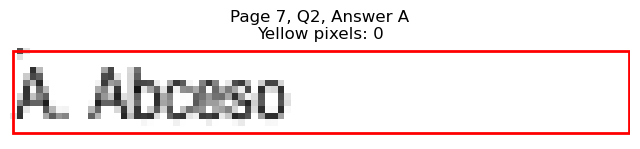

Page 7, Q2 - B: Detected box: x0=56.6, y0=215.6, x1=102.9, y1=228.3
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 207
Page 7, Q2, B: Yellow percentage: 0.0%


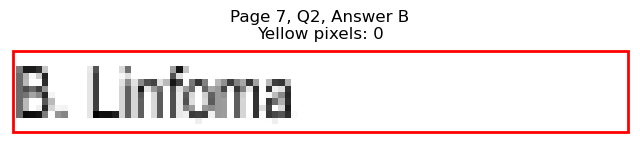

Page 7, Q2 - C: Detected box: x0=315.4, y0=278.8, x1=355.7, y1=291.4
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 341
Page 7, Q2, C: Yellow percentage: 0.0%


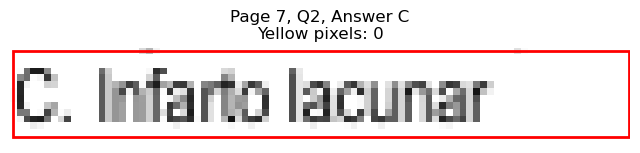

Page 7, Q2 - D: Detected box: x0=315.4, y0=215.6, x1=376.7, y1=228.3
Page 7, Q2, D: Yellow pixels: 112
Page 7, Q2, D: Total non-white pixels: 409
Page 7, Q2, D: Yellow percentage: 27.4%


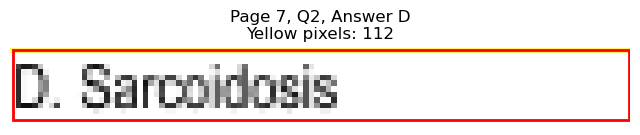


Page 7, Q2 - Selected Answer: D (based on yellow pixel count)
Page 7, Q3 - A: Detected box: x0=56.6, y0=278.8, x1=161.1, y1=291.4
Page 7, Q3, A: Yellow pixels: 1618
Page 7, Q3, A: Total non-white pixels: 2184
Page 7, Q3, A: Yellow percentage: 74.1%


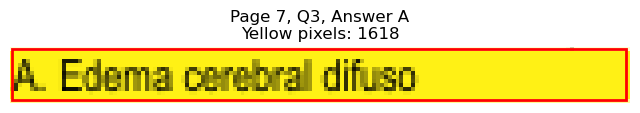

Page 7, Q3 - B: Detected box: x0=56.6, y0=291.4, x1=153.0, y1=304.0
Page 7, Q3, B: Yellow pixels: 148
Page 7, Q3, B: Total non-white pixels: 605
Page 7, Q3, B: Yellow percentage: 24.5%


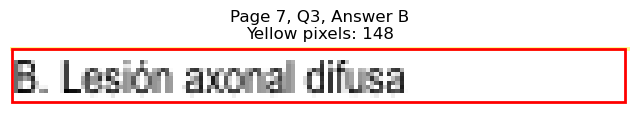

Page 7, Q3 - C: Detected box: x0=315.4, y0=278.8, x1=387.8, y1=291.4
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 341
Page 7, Q3, C: Yellow percentage: 0.0%


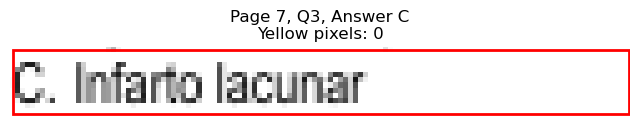

Page 7, Q3 - D: Detected box: x0=315.4, y0=291.4, x1=403.3, y1=304.0
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 412
Page 7, Q3, D: Yellow percentage: 0.0%


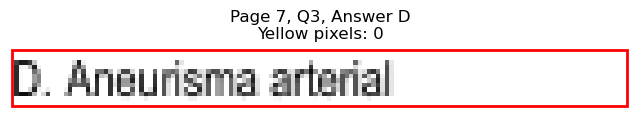


Page 7, Q3 - Selected Answer: A (based on yellow pixel count)
Page 7, Q4 - A: Detected box: x0=56.6, y0=341.9, x1=116.9, y1=354.6
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 301
Page 7, Q4, A: Yellow percentage: 0.0%


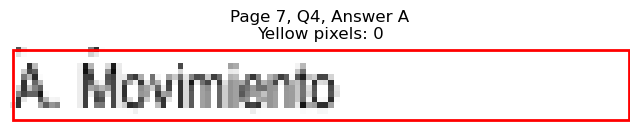

Page 7, Q4 - B: Detected box: x0=56.6, y0=354.5, x1=177.1, y1=367.2
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 580
Page 7, Q4, B: Yellow percentage: 0.0%


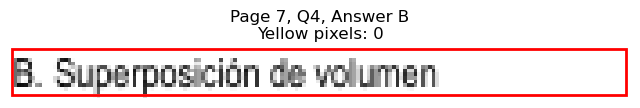

Page 7, Q4 - C: Detected box: x0=315.4, y0=341.9, x1=389.7, y1=354.6
Page 7, Q4, C: Yellow pixels: 125
Page 7, Q4, C: Total non-white pixels: 484
Page 7, Q4, C: Yellow percentage: 25.8%


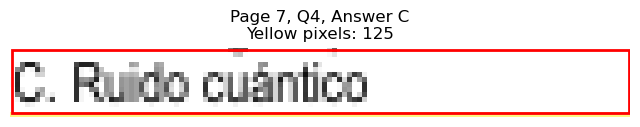

Page 7, Q4 - D: Detected box: x0=315.4, y0=354.5, x1=392.8, y1=367.2
Page 7, Q4, D: Yellow pixels: 1390
Page 7, Q4, D: Total non-white pixels: 1792
Page 7, Q4, D: Yellow percentage: 77.6%


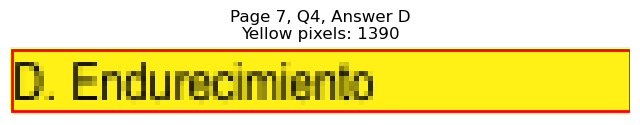


Page 7, Q4 - Selected Answer: D (based on yellow pixel count)
Page 7, Q5 - A: Detected box: x0=56.6, y0=392.3, x1=112.0, y1=405.0
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 256
Page 7, Q5, A: Yellow percentage: 0.0%


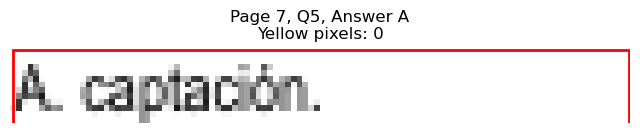

Page 7, Q5 - B: Detected box: x0=56.6, y0=404.9, x1=112.0, y1=417.6
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 258
Page 7, Q5, B: Yellow percentage: 0.0%


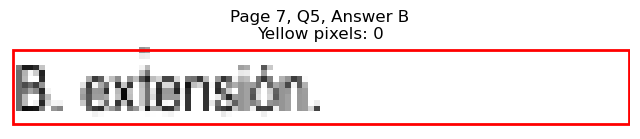

Page 7, Q5 - C: Detected box: x0=315.4, y0=392.3, x1=368.2, y1=405.0
Page 7, Q5, C: Yellow pixels: 1168
Page 7, Q5, C: Total non-white pixels: 1352
Page 7, Q5, C: Yellow percentage: 86.4%


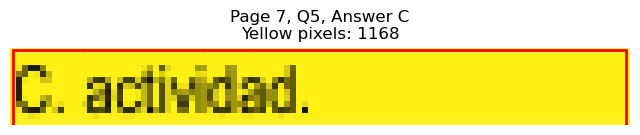

Page 7, Q5 - D: Detected box: x0=315.4, y0=404.9, x1=362.7, y1=417.6
Page 7, Q5, D: Yellow pixels: 98
Page 7, Q5, D: Total non-white pixels: 304
Page 7, Q5, D: Yellow percentage: 32.2%


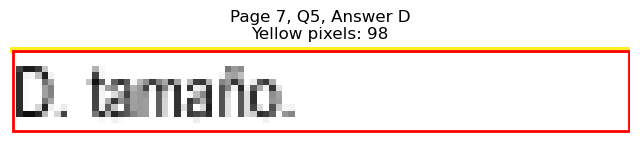


Page 7, Q5 - Selected Answer: C (based on yellow pixel count)
Page 7, Q6 - A: Detected box: x0=56.6, y0=455.5, x1=146.1, y1=468.1
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 370
Page 7, Q6, A: Yellow percentage: 0.0%


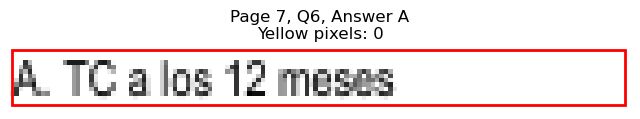

Page 7, Q6 - B: Detected box: x0=56.6, y0=468.1, x1=102.9, y1=480.7
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 199
Page 7, Q6, B: Yellow percentage: 0.0%


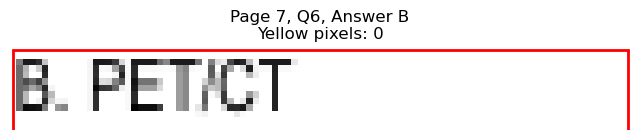

Page 7, Q6 - C: Detected box: x0=315.4, y0=455.5, x1=359.7, y1=468.1
Page 7, Q6, C: Yellow pixels: 95
Page 7, Q6, C: Total non-white pixels: 307
Page 7, Q6, C: Yellow percentage: 30.9%


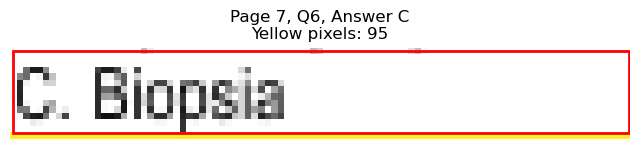

Page 7, Q6 - D: Detected box: x0=315.4, y0=468.1, x1=394.3, y1=480.7
Page 7, Q6, D: Yellow pixels: 1411
Page 7, Q6, D: Total non-white pixels: 1690
Page 7, Q6, D: Yellow percentage: 83.5%


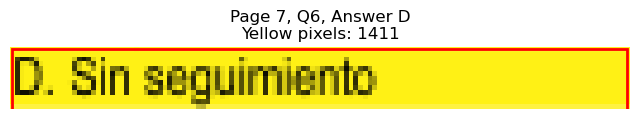


Page 7, Q6 - Selected Answer: D (based on yellow pixel count)
Page 7, Q7 - A: Detected box: x0=56.6, y0=518.6, x1=102.9, y1=531.2
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 193
Page 7, Q7, A: Yellow percentage: 0.0%


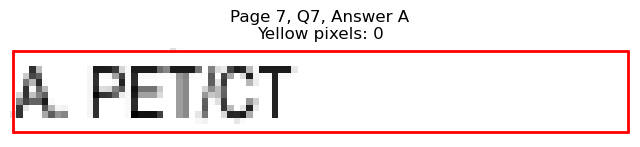

Page 7, Q7 - B: Detected box: x0=56.6, y0=531.2, x1=82.8, y1=543.8
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 93
Page 7, Q7, B: Yellow percentage: 0.0%


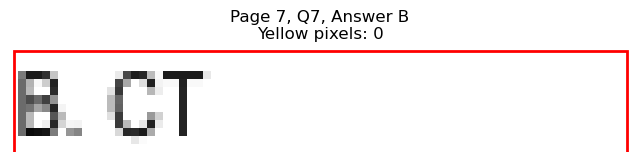

Page 7, Q7 - C: Detected box: x0=315.4, y0=518.6, x1=428.3, y1=531.2
Page 7, Q7, C: Yellow pixels: 1729
Page 7, Q7, C: Total non-white pixels: 2296
Page 7, Q7, C: Yellow percentage: 75.3%


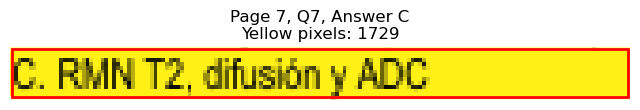

Page 7, Q7 - D: Detected box: x0=315.4, y0=531.2, x1=440.3, y1=543.8
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 709
Page 7, Q7, D: Yellow percentage: 0.0%


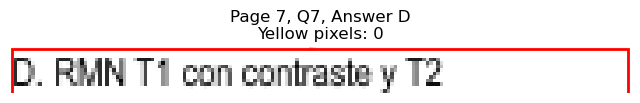


Page 7, Q7 - Selected Answer: C (based on yellow pixel count)
Page 7, Q8 - A: Detected box: x0=56.6, y0=581.7, x1=106.9, y1=594.3
Page 7, Q8, A: Yellow pixels: 101
Page 7, Q8, A: Total non-white pixels: 304
Page 7, Q8, A: Yellow percentage: 33.2%


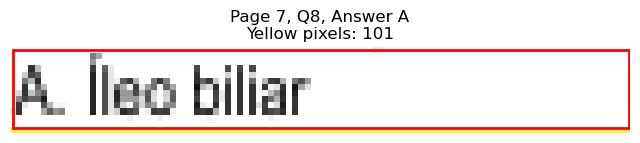

Page 7, Q8 - B: Detected box: x0=56.6, y0=594.3, x1=131.1, y1=606.9
Page 7, Q8, B: Yellow pixels: 1351
Page 7, Q8, B: Total non-white pixels: 1638
Page 7, Q8, B: Yellow percentage: 82.5%


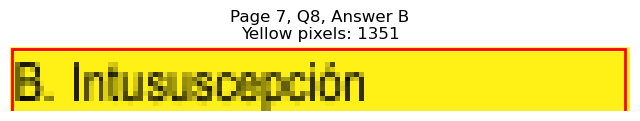

Page 7, Q8 - C: Detected box: x0=315.4, y0=581.7, x1=370.1, y1=594.3
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 271
Page 7, Q8, C: Yellow percentage: 0.0%


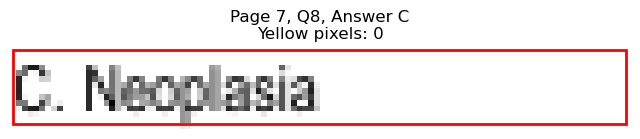

Page 7, Q8 - D: Detected box: x0=315.4, y0=594.3, x1=356.6, y1=606.9
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 188
Page 7, Q8, D: Yellow percentage: 0.0%


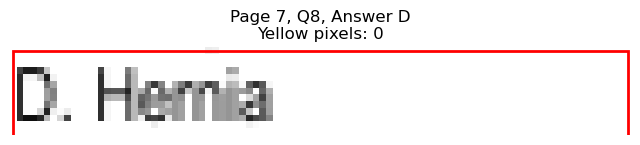


Page 7, Q8 - Selected Answer: B (based on yellow pixel count)
Page 7, Q9 - A: Detected box: x0=56.6, y0=644.8, x1=138.5, y1=657.5
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 381
Page 7, Q9, A: Yellow percentage: 0.0%


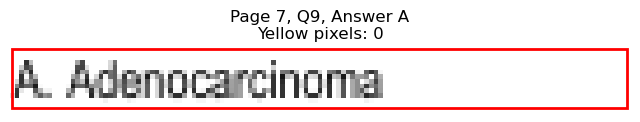

Page 7, Q9 - B: Detected box: x0=56.6, y0=657.4, x1=113.9, y1=670.1
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 310
Page 7, Q9, B: Yellow percentage: 0.0%


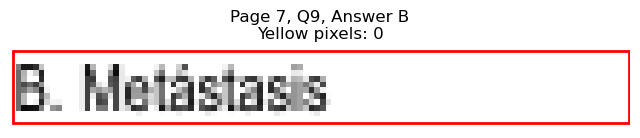

Page 7, Q9 - C: Detected box: x0=315.4, y0=644.8, x1=366.2, y1=657.5
Page 7, Q9, C: Yellow pixels: 102
Page 7, Q9, C: Total non-white pixels: 338
Page 7, Q9, C: Yellow percentage: 30.2%


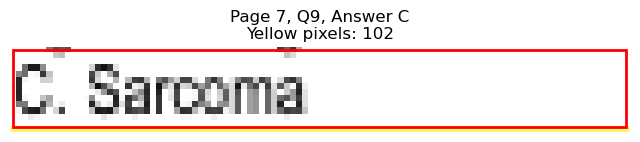

Page 7, Q9 - D: Detected box: x0=315.4, y0=657.4, x1=377.2, y1=670.1
Page 7, Q9, D: Yellow pixels: 1240
Page 7, Q9, D: Total non-white pixels: 1582
Page 7, Q9, D: Yellow percentage: 78.4%


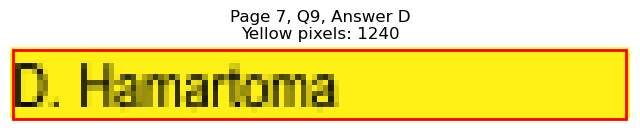


Page 7, Q9 - Selected Answer: D (based on yellow pixel count)
Page 7, Q10 - A: Detected box: x0=56.6, y0=708.0, x1=124.0, y1=720.6
Page 7, Q10, A: Yellow pixels: 118
Page 7, Q10, A: Total non-white pixels: 449
Page 7, Q10, A: Yellow percentage: 26.3%


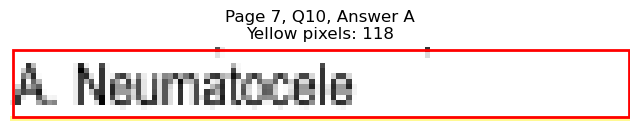

Page 7, Q10 - B: Detected box: x0=56.6, y0=720.6, x1=90.9, y1=733.2
Page 7, Q10, B: Yellow pixels: 968
Page 7, Q10, B: Total non-white pixels: 1190
Page 7, Q10, B: Yellow percentage: 81.3%


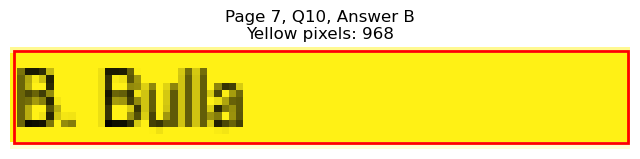

Page 7, Q10 - C: Detected box: x0=315.4, y0=708.0, x1=389.7, y1=720.6
Page 7, Q10, C: Yellow pixels: 0
Page 7, Q10, C: Total non-white pixels: 362
Page 7, Q10, C: Yellow percentage: 0.0%


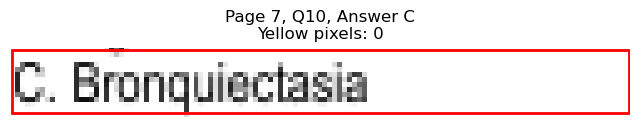

Page 7, Q10 - D: Detected box: x0=315.4, y0=720.6, x1=393.8, y1=733.2
Page 7, Q10, D: Yellow pixels: 0
Page 7, Q10, D: Total non-white pixels: 385
Page 7, Q10, D: Yellow percentage: 0.0%


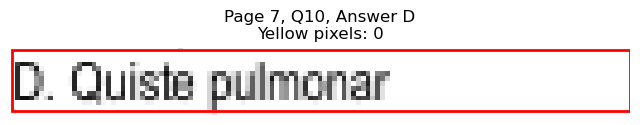


Page 7, Q10 - Selected Answer: B (based on yellow pixel count)

Page 8: Found 11 questions
Page 8, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=117.6, y1=127.3
Page 8, Q1, A: Yellow pixels: 112
Page 8, Q1, A: Total non-white pixels: 429
Page 8, Q1, A: Yellow percentage: 26.1%


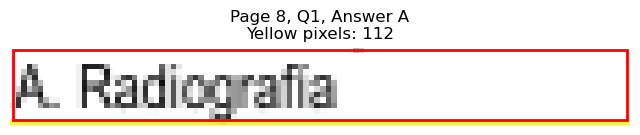

Page 8, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=109.5, y1=139.9
Page 8, Q1, B: Yellow pixels: 1134
Page 8, Q1, B: Total non-white pixels: 1352
Page 8, Q1, B: Yellow percentage: 83.9%


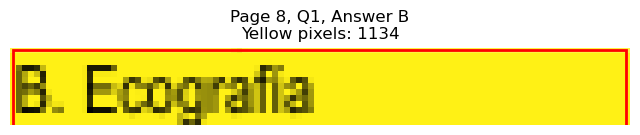

Page 8, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=376.3, y1=127.3
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 276
Page 8, Q1, C: Yellow percentage: 0.0%


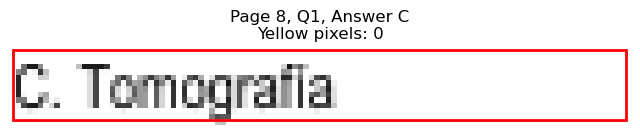

Page 8, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=377.7, y1=139.9
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 301
Page 8, Q1, D: Yellow percentage: 0.0%


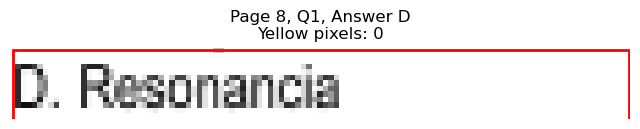


Page 8, Q1 - Selected Answer: B (based on yellow pixel count)
Page 8, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=101.4, y1=177.8
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 292
Page 8, Q2, A: Yellow percentage: 0.0%


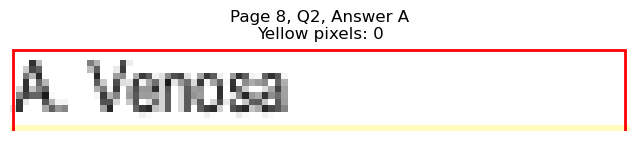

Page 8, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=97.0, y1=190.4
Page 8, Q2, B: Yellow pixels: 950
Page 8, Q2, B: Total non-white pixels: 1274
Page 8, Q2, B: Yellow percentage: 74.6%


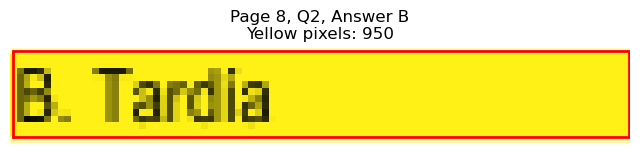

Page 8, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=358.6, y1=177.8
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 197
Page 8, Q2, C: Yellow percentage: 0.0%


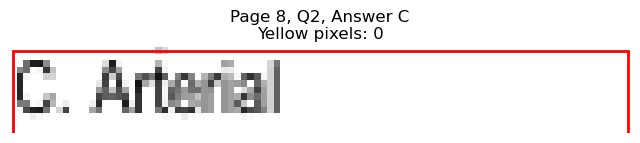

Page 8, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=382.7, y1=190.4
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 306
Page 8, Q2, D: Yellow percentage: 0.0%


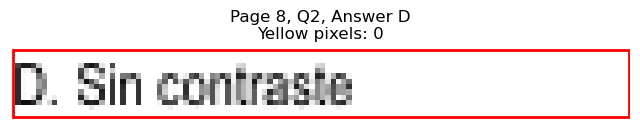


Page 8, Q2 - Selected Answer: B (based on yellow pixel count)
Page 8, Q3 - A: Detected box: x0=56.6, y0=240.8, x1=73.3, y1=253.5
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 51
Page 8, Q3, A: Yellow percentage: 0.0%


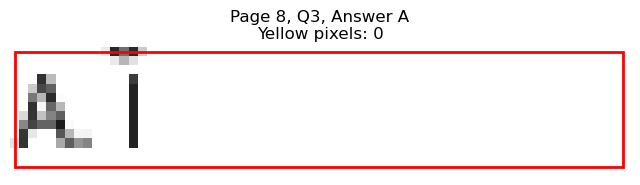

Page 8, Q3 - B: Detected box: x0=56.6, y0=253.4, x1=75.9, y1=266.1
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 66
Page 8, Q3, B: Yellow percentage: 0.0%


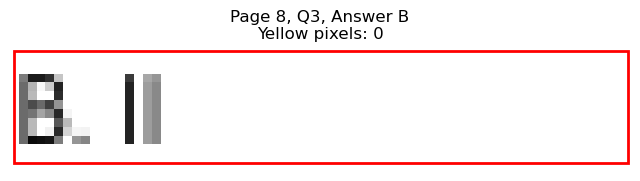

Page 8, Q3 - C: Detected box: x0=315.4, y0=240.8, x1=338.6, y1=253.5
Page 8, Q3, C: Yellow pixels: 74
Page 8, Q3, C: Total non-white pixels: 152
Page 8, Q3, C: Yellow percentage: 48.7%


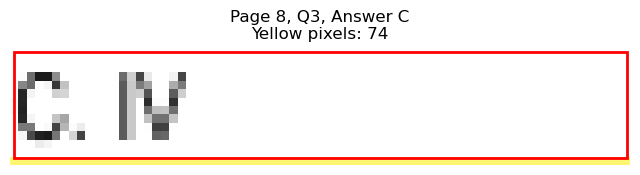

Page 8, Q3 - D: Detected box: x0=315.4, y0=253.4, x1=337.6, y1=266.1
Page 8, Q3, D: Yellow pixels: 879
Page 8, Q3, D: Total non-white pixels: 1022
Page 8, Q3, D: Yellow percentage: 86.0%


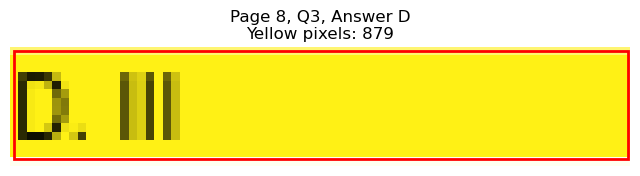


Page 8, Q3 - Selected Answer: D (based on yellow pixel count)
Page 8, Q4 - A: Detected box: x0=56.6, y0=291.4, x1=188.2, y1=304.0
Page 8, Q4, A: Yellow pixels: 1878
Page 8, Q4, A: Total non-white pixels: 2562
Page 8, Q4, A: Yellow percentage: 73.3%


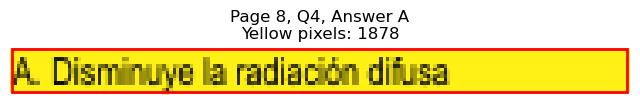

Page 8, Q4 - B: Detected box: x0=56.6, y0=304.0, x1=233.3, y1=316.6
Page 8, Q4, B: Yellow pixels: 223
Page 8, Q4, B: Total non-white pixels: 1302
Page 8, Q4, B: Yellow percentage: 17.1%


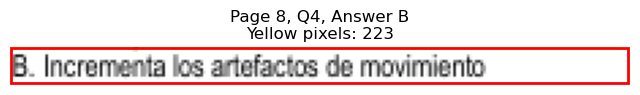

Page 8, Q4 - C: Detected box: x0=315.4, y0=291.4, x1=489.6, y1=304.0
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 851
Page 8, Q4, C: Yellow percentage: 0.0%


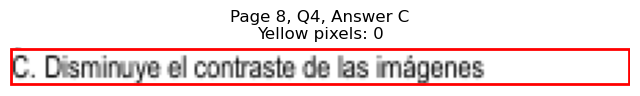

Page 8, Q4 - D: Detected box: x0=315.4, y0=304.0, x1=459.9, y1=316.6
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 680
Page 8, Q4, D: Yellow percentage: 0.0%


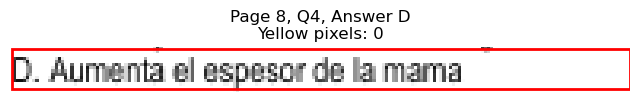


Page 8, Q4 - Selected Answer: A (based on yellow pixel count)
Page 8, Q5 - A: Detected box: x0=56.6, y0=367.1, x1=160.1, y1=379.8
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 484
Page 8, Q5, A: Yellow percentage: 0.0%


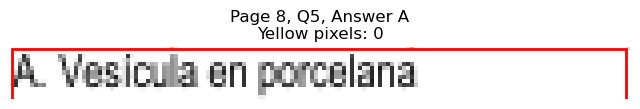

Page 8, Q5 - B: Detected box: x0=56.6, y0=379.7, x1=143.5, y1=392.4
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 457
Page 8, Q5, B: Yellow percentage: 0.0%


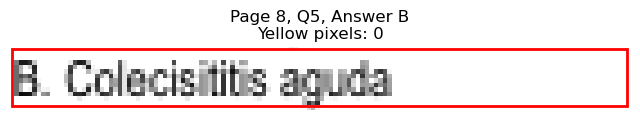

Page 8, Q5 - C: Detected box: x0=315.4, y0=367.1, x1=435.9, y1=379.8
Page 8, Q5, C: Yellow pixels: 1800
Page 8, Q5, C: Total non-white pixels: 2223
Page 8, Q5, C: Yellow percentage: 81.0%


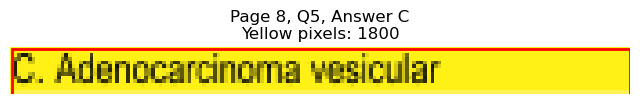

Page 8, Q5 - D: Detected box: x0=315.4, y0=379.7, x1=401.3, y1=392.4
Page 8, Q5, D: Yellow pixels: 137
Page 8, Q5, D: Total non-white pixels: 559
Page 8, Q5, D: Yellow percentage: 24.5%


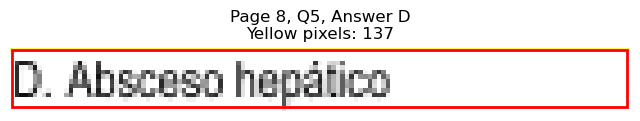


Page 8, Q5 - Selected Answer: C (based on yellow pixel count)
Page 8, Q6 - A: Detected box: x0=56.6, y0=417.6, x1=167.1, y1=430.3
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 531
Page 8, Q6, A: Yellow percentage: 0.0%


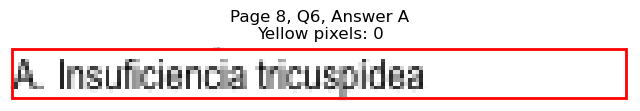

Page 8, Q6 - B: Detected box: x0=56.6, y0=430.2, x1=161.5, y1=442.9
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 508
Page 8, Q6, B: Yellow percentage: 0.0%


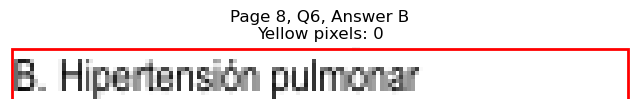

Page 8, Q6 - C: Detected box: x0=315.4, y0=417.6, x1=393.8, y1=430.3
Page 8, Q6, C: Yellow pixels: 1259
Page 8, Q6, C: Total non-white pixels: 1806
Page 8, Q6, C: Yellow percentage: 69.7%


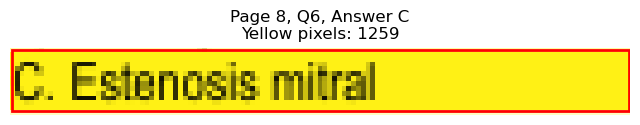

Page 8, Q6 - D: Detected box: x0=315.4, y0=430.2, x1=371.3, y1=442.9
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 371
Page 8, Q6, D: Yellow percentage: 0.0%


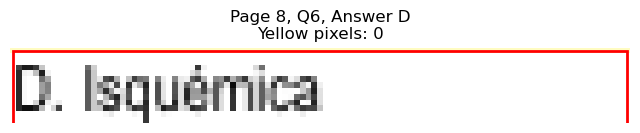


Page 8, Q6 - Selected Answer: C (based on yellow pixel count)
Page 8, Q7 - A: Detected box: x0=56.6, y0=468.1, x1=164.1, y1=480.7
Page 8, Q7, A: Yellow pixels: 1694
Page 8, Q7, A: Total non-white pixels: 2067
Page 8, Q7, A: Yellow percentage: 82.0%


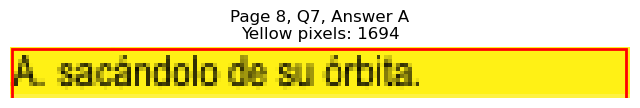

Page 8, Q7 - B: Detected box: x0=56.6, y0=480.8, x1=182.2, y1=493.4
Page 8, Q7, B: Yellow pixels: 177
Page 8, Q7, B: Total non-white pixels: 756
Page 8, Q7, B: Yellow percentage: 23.4%


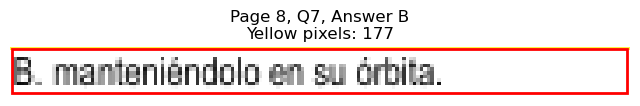

Page 8, Q7 - C: Detected box: x0=315.4, y0=468.1, x1=378.2, y1=480.7
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 249
Page 8, Q7, C: Yellow percentage: 0.0%


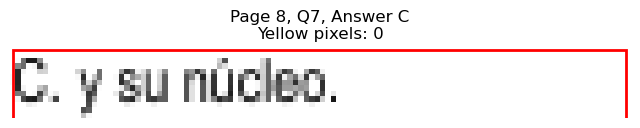

Page 8, Q7 - D: Detected box: x0=315.4, y0=480.8, x1=417.3, y1=493.4
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 469
Page 8, Q7, D: Yellow percentage: 0.0%


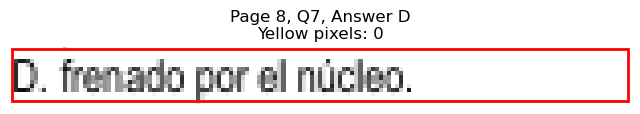


Page 8, Q7 - Selected Answer: A (based on yellow pixel count)
Page 8, Q8 - A: Detected box: x0=56.6, y0=543.8, x1=162.6, y1=556.4
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 516
Page 8, Q8, A: Yellow percentage: 0.0%


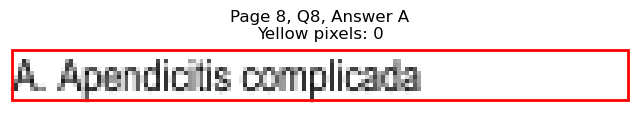

Page 8, Q8 - B: Detected box: x0=56.6, y0=556.5, x1=220.4, y1=569.1
Page 8, Q8, B: Yellow pixels: 2156
Page 8, Q8, B: Total non-white pixels: 3010
Page 8, Q8, B: Yellow percentage: 71.6%


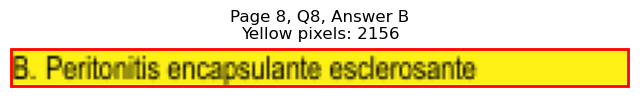

Page 8, Q8 - C: Detected box: x0=315.4, y0=543.8, x1=432.3, y1=556.4
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 595
Page 8, Q8, C: Yellow percentage: 0.0%


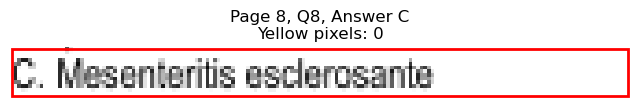

Page 8, Q8 - D: Detected box: x0=315.4, y0=556.5, x1=390.2, y1=569.1
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 363
Page 8, Q8, D: Yellow percentage: 0.0%


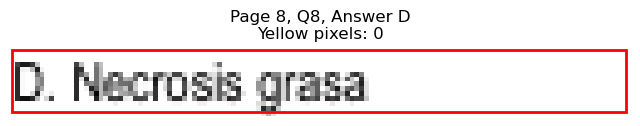


Page 8, Q8 - Selected Answer: B (based on yellow pixel count)
Page 8, Q9 - A: Detected box: x0=56.6, y0=619.6, x1=168.6, y1=632.3
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 529
Page 8, Q9, A: Yellow percentage: 0.0%


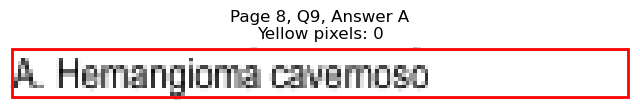

Page 8, Q9 - B: Detected box: x0=56.6, y0=632.2, x1=146.1, y1=644.9
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 438
Page 8, Q9, B: Yellow percentage: 0.0%


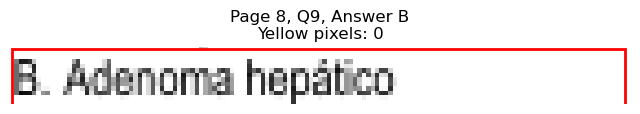

Page 8, Q9 - C: Detected box: x0=315.4, y0=619.6, x1=430.4, y1=632.3
Page 8, Q9, C: Yellow pixels: 166
Page 8, Q9, C: Total non-white pixels: 729
Page 8, Q9, C: Yellow percentage: 22.8%


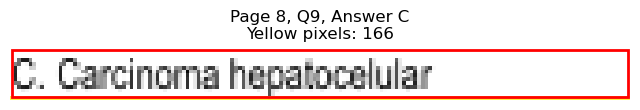

Page 8, Q9 - D: Detected box: x0=315.4, y0=632.2, x1=423.4, y1=644.9
Page 8, Q9, D: Yellow pixels: 1650
Page 8, Q9, D: Total non-white pixels: 2067
Page 8, Q9, D: Yellow percentage: 79.8%


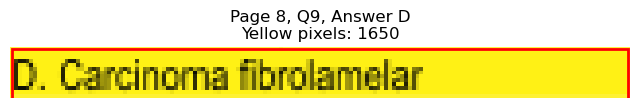


Page 8, Q9 - Selected Answer: D (based on yellow pixel count)
Page 8, Q10 - A: Detected box: x0=56.6, y0=682.6, x1=139.0, y1=695.3
Page 8, Q10, A: Yellow pixels: 0
Page 8, Q10, A: Total non-white pixels: 357
Page 8, Q10, A: Yellow percentage: 0.0%


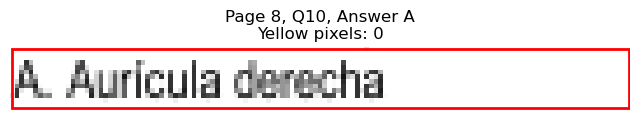

Page 8, Q10 - B: Detected box: x0=56.6, y0=695.4, x1=150.5, y1=708.0
Page 8, Q10, B: Yellow pixels: 0
Page 8, Q10, B: Total non-white pixels: 464
Page 8, Q10, B: Yellow percentage: 0.0%


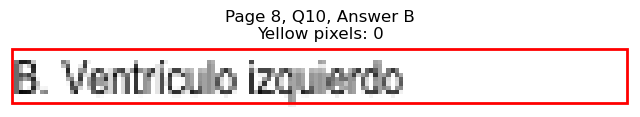

Page 8, Q10 - C: Detected box: x0=315.4, y0=682.6, x1=402.3, y1=695.3
Page 8, Q10, C: Yellow pixels: 0
Page 8, Q10, C: Total non-white pixels: 406
Page 8, Q10, C: Yellow percentage: 0.0%


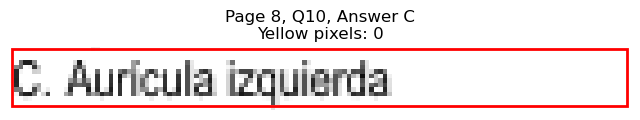

Page 8, Q10 - D: Detected box: x0=315.4, y0=695.4, x1=405.8, y1=708.0
Page 8, Q10, D: Yellow pixels: 1509
Page 8, Q10, D: Total non-white pixels: 1833
Page 8, Q10, D: Yellow percentage: 82.3%


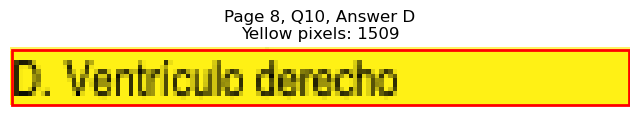


Page 8, Q10 - Selected Answer: D (based on yellow pixel count)
Page 8, Q11 - A: Detected box: x0=56.6, y0=733.2, x1=80.9, y1=745.8
Page 8, Q11, A: Yellow pixels: 916
Page 8, Q11, A: Total non-white pixels: 975
Page 8, Q11, A: Yellow percentage: 93.9%


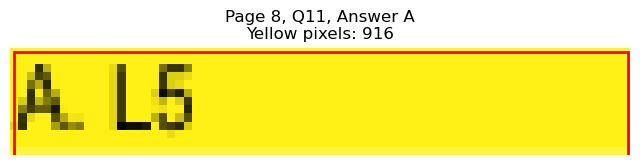

Page 8, Q11 - B: Detected box: x0=56.6, y0=745.8, x1=80.9, y1=758.4
Page 8, Q11, B: Yellow pixels: 75
Page 8, Q11, B: Total non-white pixels: 160
Page 8, Q11, B: Yellow percentage: 46.9%


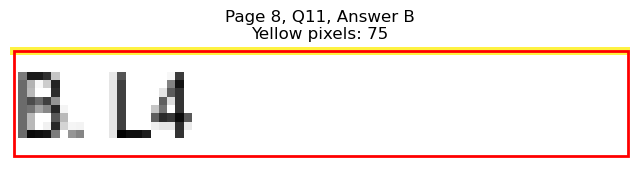

Page 8, Q11 - C: Detected box: x0=315.4, y0=733.2, x1=340.1, y1=745.8
Page 8, Q11, C: Yellow pixels: 0
Page 8, Q11, C: Total non-white pixels: 78
Page 8, Q11, C: Yellow percentage: 0.0%


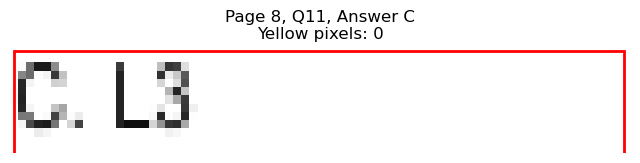

Page 8, Q11 - D: Detected box: x0=315.4, y0=745.8, x1=337.6, y1=758.4
Page 8, Q11, D: Yellow pixels: 0
Page 8, Q11, D: Total non-white pixels: 77
Page 8, Q11, D: Yellow percentage: 0.0%


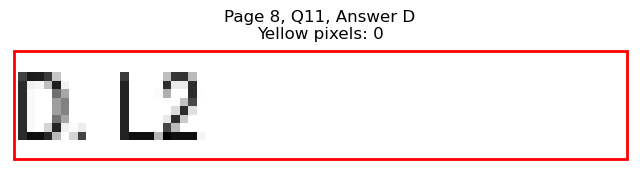


Page 8, Q11 - Selected Answer: A (based on yellow pixel count)

Page 9: Found 11 questions
Page 9, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=119.9, y1=114.7
Page 9, Q1, A: Yellow pixels: 1260
Page 9, Q1, A: Total non-white pixels: 1482
Page 9, Q1, A: Yellow percentage: 85.0%


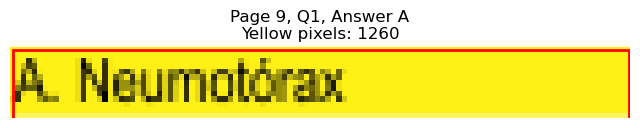

Page 9, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=139.6, y1=127.3
Page 9, Q1, B: Yellow pixels: 134
Page 9, Q1, B: Total non-white pixels: 517
Page 9, Q1, B: Yellow percentage: 25.9%


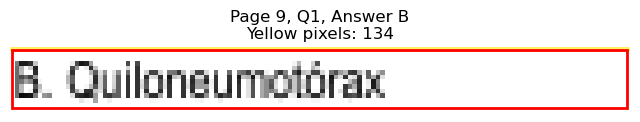

Page 9, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=399.3, y1=114.7
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 413
Page 9, Q1, C: Yellow percentage: 0.0%


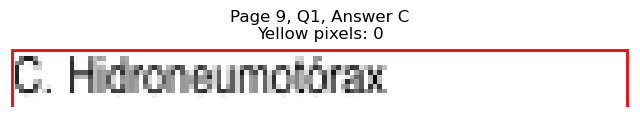

Page 9, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=401.7, y1=127.3
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 396
Page 9, Q1, D: Yellow percentage: 0.0%


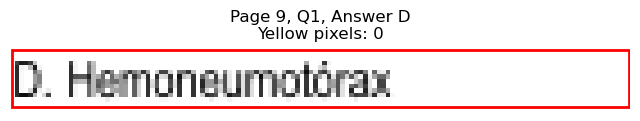


Page 9, Q1 - Selected Answer: A (based on yellow pixel count)
Page 9, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=130.5, y1=177.8
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 476
Page 9, Q2, A: Yellow percentage: 0.0%


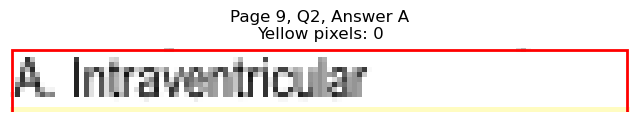

Page 9, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=103.9, y1=190.4
Page 9, Q2, B: Yellow pixels: 1005
Page 9, Q2, B: Total non-white pixels: 1372
Page 9, Q2, B: Yellow percentage: 73.3%


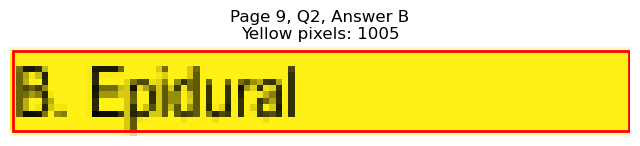

Page 9, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=366.2, y1=177.8
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 222
Page 9, Q2, C: Yellow percentage: 0.0%


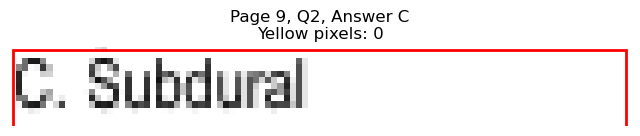

Page 9, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=390.8, y1=190.4
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 354
Page 9, Q2, D: Yellow percentage: 0.0%


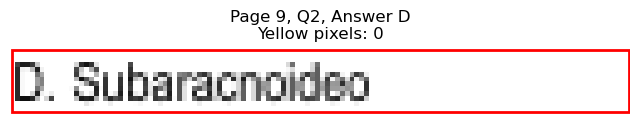


Page 9, Q2 - Selected Answer: B (based on yellow pixel count)
Page 9, Q3 - A: Detected box: x0=56.6, y0=228.2, x1=119.9, y1=240.9
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 277
Page 9, Q3, A: Yellow percentage: 0.0%


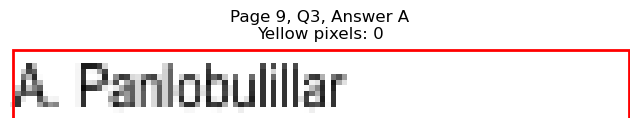

Page 9, Q3 - B: Detected box: x0=56.6, y0=240.8, x1=100.5, y1=253.5
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 216
Page 9, Q3, B: Yellow percentage: 0.0%


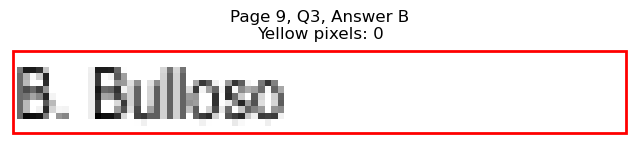

Page 9, Q3 - C: Detected box: x0=315.4, y0=228.2, x1=373.1, y1=240.9
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 377
Page 9, Q3, C: Yellow percentage: 0.0%


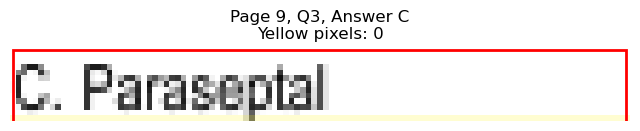

Page 9, Q3 - D: Detected box: x0=315.4, y0=240.8, x1=390.2, y1=253.5
Page 9, Q3, D: Yellow pixels: 1368
Page 9, Q3, D: Total non-white pixels: 1764
Page 9, Q3, D: Yellow percentage: 77.6%


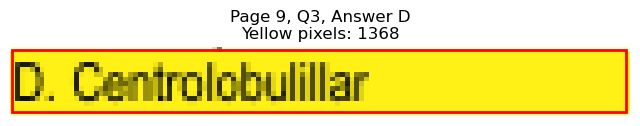


Page 9, Q3 - Selected Answer: D (based on yellow pixel count)
Page 9, Q4 - A: Detected box: x0=56.6, y0=291.4, x1=132.0, y1=304.0
Page 9, Q4, A: Yellow pixels: 127
Page 9, Q4, A: Total non-white pixels: 489
Page 9, Q4, A: Yellow percentage: 26.0%


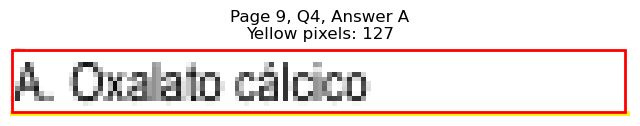

Page 9, Q4 - B: Detected box: x0=56.6, y0=304.0, x1=153.0, y1=316.6
Page 9, Q4, B: Yellow pixels: 1576
Page 9, Q4, B: Total non-white pixels: 1924
Page 9, Q4, B: Yellow percentage: 81.9%


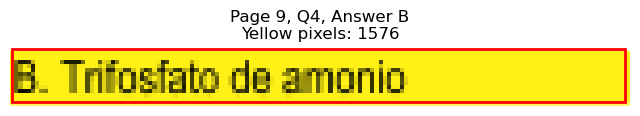

Page 9, Q4 - C: Detected box: x0=315.4, y0=291.4, x1=390.2, y1=304.0
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 349
Page 9, Q4, C: Yellow percentage: 0.0%


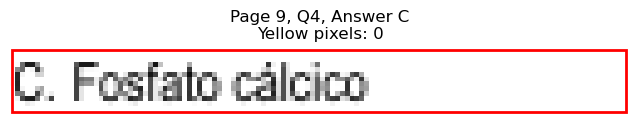

Page 9, Q4 - D: Detected box: x0=315.4, y0=304.0, x1=364.1, y1=316.6
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 233
Page 9, Q4, D: Yellow percentage: 0.0%


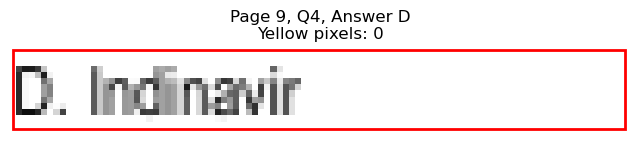


Page 9, Q4 - Selected Answer: B (based on yellow pixel count)
Page 9, Q5 - A: Detected box: x0=56.6, y0=367.1, x1=118.9, y1=379.8
Page 9, Q5, A: Yellow pixels: 1214
Page 9, Q5, A: Total non-white pixels: 1469
Page 9, Q5, A: Yellow percentage: 82.6%


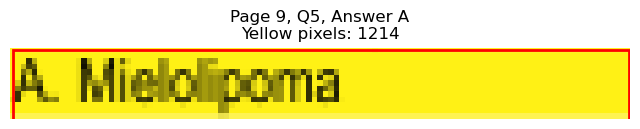

Page 9, Q5 - B: Detected box: x0=56.6, y0=379.7, x1=113.9, y1=392.4
Page 9, Q5, B: Yellow pixels: 108
Page 9, Q5, B: Total non-white pixels: 418
Page 9, Q5, B: Yellow percentage: 25.8%


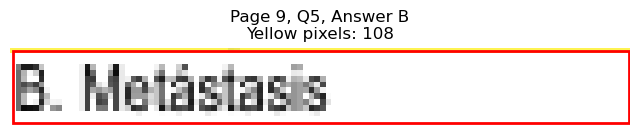

Page 9, Q5 - C: Detected box: x0=315.4, y0=367.1, x1=380.2, y1=379.8
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 303
Page 9, Q5, C: Yellow percentage: 0.0%


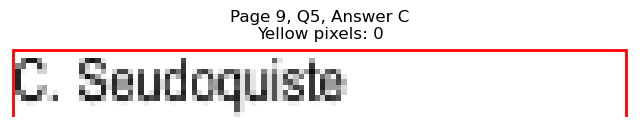

Page 9, Q5 - D: Detected box: x0=315.4, y0=379.7, x1=377.2, y1=392.4
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 297
Page 9, Q5, D: Yellow percentage: 0.0%


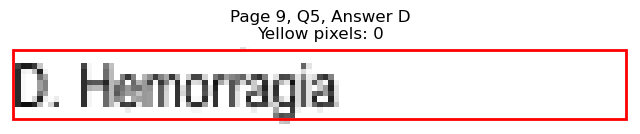


Page 9, Q5 - Selected Answer: A (based on yellow pixel count)
Page 9, Q6 - A: Detected box: x0=56.6, y0=417.6, x1=192.6, y1=430.3
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 686
Page 9, Q6, A: Yellow percentage: 0.0%


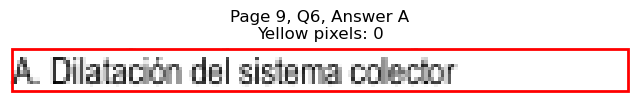

Page 9, Q6 - B: Detected box: x0=56.6, y0=430.2, x1=269.4, y1=442.9
Page 9, Q6, B: Yellow pixels: 62
Page 9, Q6, B: Total non-white pixels: 1121
Page 9, Q6, B: Yellow percentage: 5.5%


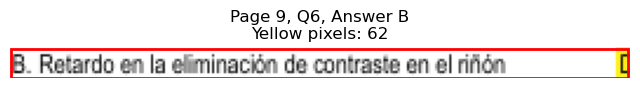

Page 9, Q6 - C: Detected box: x0=315.4, y0=417.6, x1=433.4, y1=430.3
Page 9, Q6, C: Yellow pixels: 169
Page 9, Q6, C: Total non-white pixels: 762
Page 9, Q6, C: Yellow percentage: 22.2%


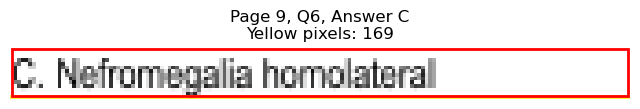

Page 9, Q6 - D: Detected box: x0=315.4, y0=430.2, x1=501.1, y1=442.9
Page 9, Q6, D: Yellow pixels: 2205
Page 9, Q6, D: Total non-white pixels: 2938
Page 9, Q6, D: Yellow percentage: 75.1%


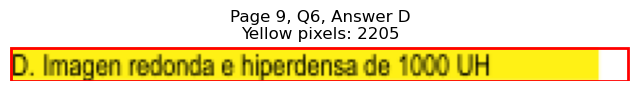


Page 9, Q6 - Selected Answer: D (based on yellow pixel count)
Page 9, Q7 - A: Detected box: x0=56.6, y0=480.8, x1=75.9, y1=493.4
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 68
Page 9, Q7, A: Yellow percentage: 0.0%


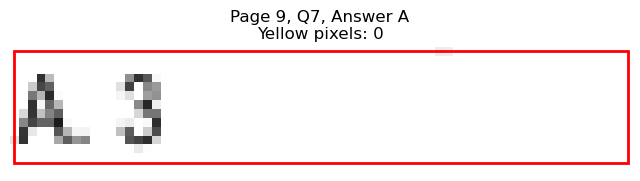

Page 9, Q7 - B: Detected box: x0=56.6, y0=493.4, x1=75.9, y1=506.0
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 74
Page 9, Q7, B: Yellow percentage: 0.0%


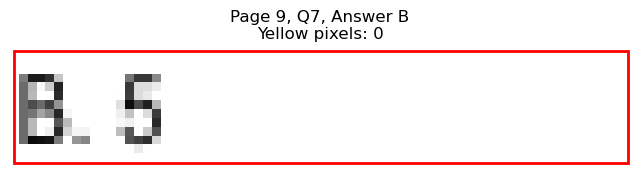

Page 9, Q7 - C: Detected box: x0=315.4, y0=480.8, x1=335.1, y1=493.4
Page 9, Q7, C: Yellow pixels: 807
Page 9, Q7, C: Total non-white pixels: 994
Page 9, Q7, C: Yellow percentage: 81.2%


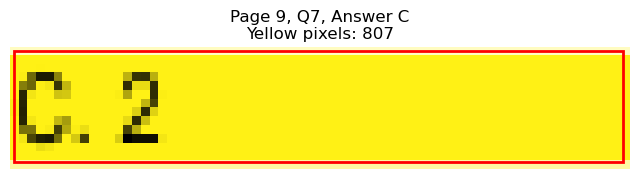

Page 9, Q7 - D: Detected box: x0=315.4, y0=493.4, x1=335.1, y1=506.0
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 144
Page 9, Q7, D: Yellow percentage: 0.0%


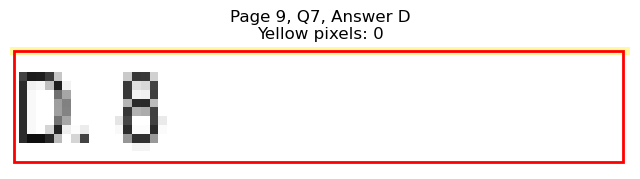


Page 9, Q7 - Selected Answer: C (based on yellow pixel count)
Page 9, Q8 - A: Detected box: x0=56.6, y0=543.8, x1=173.1, y1=556.4
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 599
Page 9, Q8, A: Yellow percentage: 0.0%


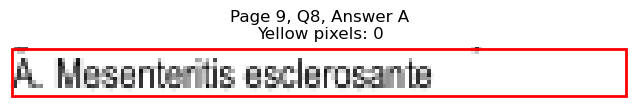

Page 9, Q8 - B: Detected box: x0=56.6, y0=556.5, x1=163.1, y1=569.1
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 538
Page 9, Q8, B: Yellow percentage: 0.0%


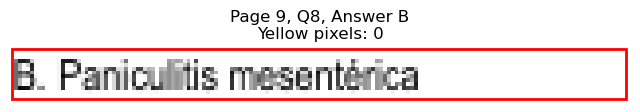

Page 9, Q8 - C: Detected box: x0=315.4, y0=543.8, x1=484.5, y1=556.4
Page 9, Q8, C: Yellow pixels: 2185
Page 9, Q8, C: Total non-white pixels: 3080
Page 9, Q8, C: Yellow percentage: 70.9%


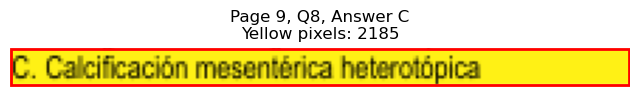

Page 9, Q8 - D: Detected box: x0=315.4, y0=556.5, x1=410.8, y1=569.1
Page 9, Q8, D: Yellow pixels: 146
Page 9, Q8, D: Total non-white pixels: 645
Page 9, Q8, D: Yellow percentage: 22.6%


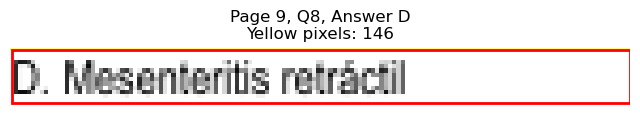


Page 9, Q8 - Selected Answer: C (based on yellow pixel count)
Page 9, Q9 - A: Detected box: x0=56.6, y0=606.9, x1=90.4, y1=619.5
Page 9, Q9, A: Yellow pixels: 0
Page 9, Q9, A: Total non-white pixels: 140
Page 9, Q9, A: Yellow percentage: 0.0%


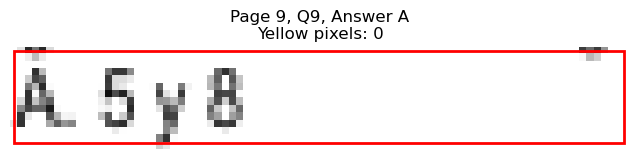

Page 9, Q9 - B: Detected box: x0=56.6, y0=619.6, x1=90.4, y1=632.3
Page 9, Q9, B: Yellow pixels: 921
Page 9, Q9, B: Total non-white pixels: 1190
Page 9, Q9, B: Yellow percentage: 77.4%


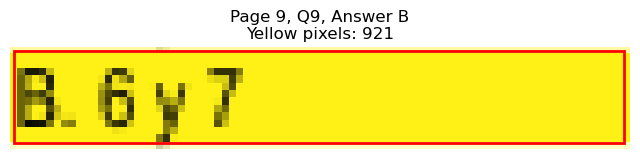

Page 9, Q9 - C: Detected box: x0=315.4, y0=606.9, x1=359.7, y1=619.5
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 158
Page 9, Q9, C: Yellow percentage: 0.0%


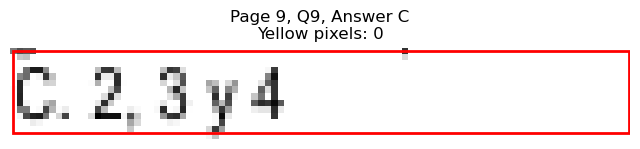

Page 9, Q9 - D: Detected box: x0=315.4, y0=619.6, x1=379.7, y1=632.3
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 239
Page 9, Q9, D: Yellow percentage: 0.0%


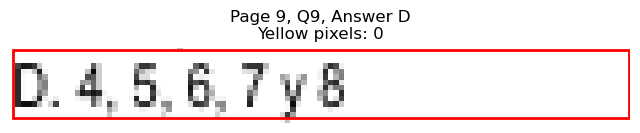


Page 9, Q9 - Selected Answer: B (based on yellow pixel count)
Page 9, Q10 - A: Detected box: x0=56.6, y0=657.4, x1=202.7, y1=670.1
Page 9, Q10, A: Yellow pixels: 0
Page 9, Q10, A: Total non-white pixels: 745
Page 9, Q10, A: Yellow percentage: 0.0%


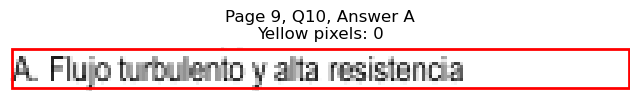

Page 9, Q10 - B: Detected box: x0=56.6, y0=670.0, x1=289.0, y1=682.7
Page 9, Q10, B: Yellow pixels: 2
Page 9, Q10, B: Total non-white pixels: 1412
Page 9, Q10, B: Yellow percentage: 0.1%


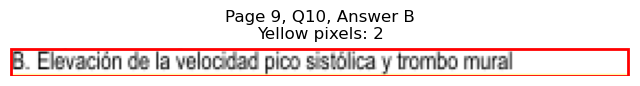

Page 9, Q10 - C: Detected box: x0=56.6, y0=682.6, x1=220.7, y1=695.3
Page 9, Q10, C: Yellow pixels: 1971
Page 9, Q10, C: Total non-white pixels: 3010
Page 9, Q10, C: Yellow percentage: 65.5%


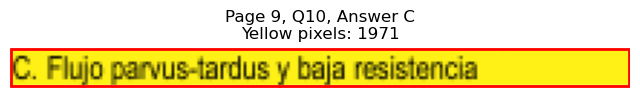

Page 9, Q10 - D: Detected box: x0=56.6, y0=695.4, x1=193.1, y1=708.0
Page 9, Q10, D: Yellow pixels: 1
Page 9, Q10, D: Total non-white pixels: 893
Page 9, Q10, D: Yellow percentage: 0.1%


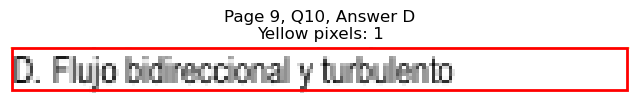


Page 9, Q10 - Selected Answer: C (based on yellow pixel count)
Page 9, Q11 - A: Detected box: x0=56.6, y0=745.8, x1=110.4, y1=758.4
Page 9, Q11, A: Yellow pixels: 0
Page 9, Q11, A: Total non-white pixels: 250
Page 9, Q11, A: Yellow percentage: 0.0%


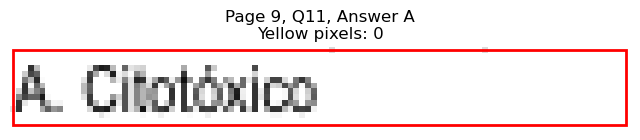

Page 9, Q11 - B: Detected box: x0=56.6, y0=758.5, x1=111.4, y1=771.1
Page 9, Q11, B: Yellow pixels: 0
Page 9, Q11, B: Total non-white pixels: 269
Page 9, Q11, B: Yellow percentage: 0.0%


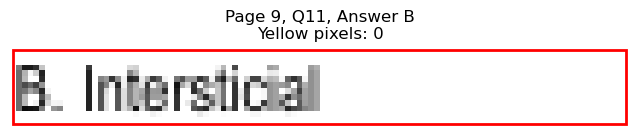

Page 9, Q11 - C: Detected box: x0=315.4, y0=745.8, x1=377.2, y1=758.4
Page 9, Q11, C: Yellow pixels: 1242
Page 9, Q11, C: Total non-white pixels: 1582
Page 9, Q11, C: Yellow percentage: 78.5%


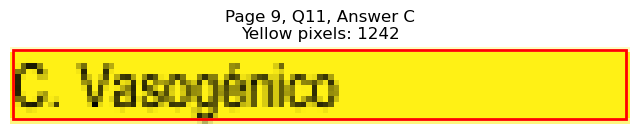

Page 9, Q11 - D: Detected box: x0=315.4, y0=758.5, x1=381.2, y1=771.1
Page 9, Q11, D: Yellow pixels: 116
Page 9, Q11, D: Total non-white pixels: 445
Page 9, Q11, D: Yellow percentage: 26.1%


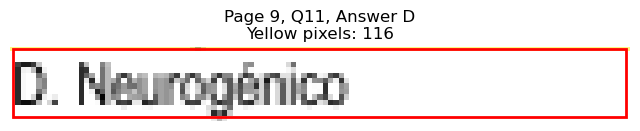


Page 9, Q11 - Selected Answer: C (based on yellow pixel count)

Page 10: Found 7 questions
Page 10, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=125.5, y1=114.7
Page 10, Q1, A: Yellow pixels: 1319
Page 10, Q1, A: Total non-white pixels: 1560
Page 10, Q1, A: Yellow percentage: 84.6%


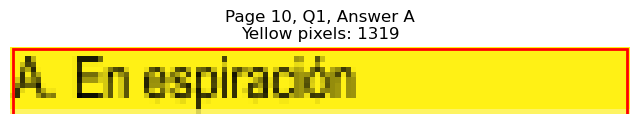

Page 10, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=127.5, y1=127.3
Page 10, Q1, B: Yellow pixels: 122
Page 10, Q1, B: Total non-white pixels: 456
Page 10, Q1, B: Yellow percentage: 26.8%


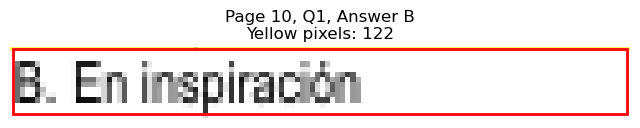

Page 10, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=456.4, y1=114.7
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 666
Page 10, Q1, C: Yellow percentage: 0.0%


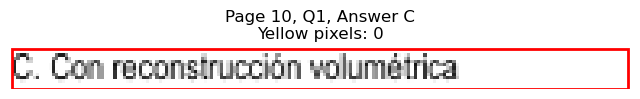

Page 10, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=379.3, y1=127.3
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 300
Page 10, Q1, D: Yellow percentage: 0.0%


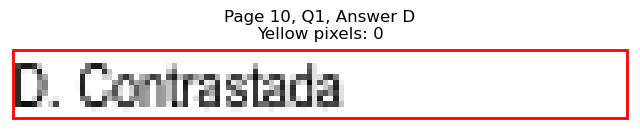


Page 10, Q1 - Selected Answer: A (based on yellow pixel count)
Page 10, Q2 - A: Detected box: x0=56.6, y0=177.7, x1=179.2, y1=190.4
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 580
Page 10, Q2, A: Yellow percentage: 0.0%


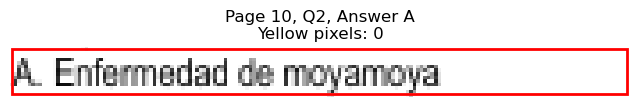

Page 10, Q2 - B: Detected box: x0=56.6, y0=190.3, x1=168.6, y1=203.0
Page 10, Q2, B: Yellow pixels: 0
Page 10, Q2, B: Total non-white pixels: 533
Page 10, Q2, B: Yellow percentage: 0.0%


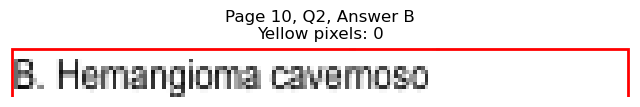

Page 10, Q2 - C: Detected box: x0=315.4, y0=177.7, x1=397.3, y1=190.4
Page 10, Q2, C: Yellow pixels: 1317
Page 10, Q2, C: Total non-white pixels: 1862
Page 10, Q2, C: Yellow percentage: 70.7%


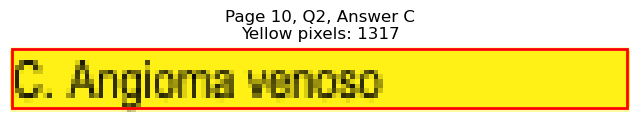

Page 10, Q2 - D: Detected box: x0=315.4, y0=190.3, x1=441.4, y1=203.0
Page 10, Q2, D: Yellow pixels: 1
Page 10, Q2, D: Total non-white pixels: 800
Page 10, Q2, D: Yellow percentage: 0.1%


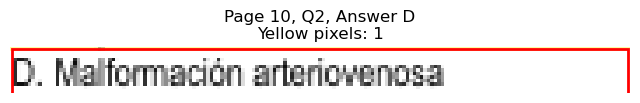


Page 10, Q2 - Selected Answer: C (based on yellow pixel count)
Page 10, Q3 - A: Detected box: x0=56.6, y0=253.4, x1=153.6, y1=266.1
Page 10, Q3, A: Yellow pixels: 148
Page 10, Q3, A: Total non-white pixels: 645
Page 10, Q3, A: Yellow percentage: 22.9%


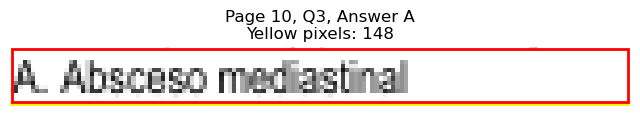

Page 10, Q3 - B: Detected box: x0=56.6, y0=266.0, x1=148.1, y1=278.7
Page 10, Q3, B: Yellow pixels: 1478
Page 10, Q3, B: Total non-white pixels: 1859
Page 10, Q3, B: Yellow percentage: 79.5%


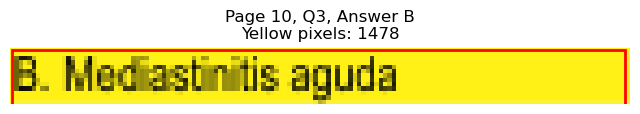

Page 10, Q3 - C: Detected box: x0=315.4, y0=253.4, x1=402.8, y1=266.1
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 435
Page 10, Q3, C: Yellow percentage: 0.0%


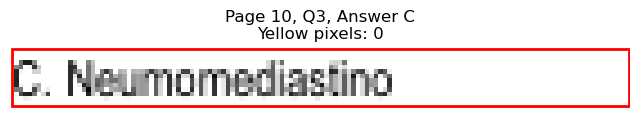

Page 10, Q3 - D: Detected box: x0=315.4, y0=266.0, x1=397.7, y1=278.7
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 412
Page 10, Q3, D: Yellow percentage: 0.0%


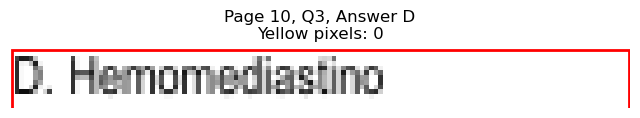


Page 10, Q3 - Selected Answer: B (based on yellow pixel count)
Page 10, Q4 - A: Detected box: x0=56.6, y0=316.6, x1=150.0, y1=329.2
Page 10, Q4, A: Yellow pixels: 1356
Page 10, Q4, A: Total non-white pixels: 2030
Page 10, Q4, A: Yellow percentage: 66.8%


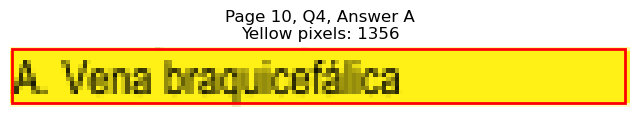

Page 10, Q4 - B: Detected box: x0=56.6, y0=329.2, x1=146.5, y1=341.8
Page 10, Q4, B: Yellow pixels: 0
Page 10, Q4, B: Total non-white pixels: 558
Page 10, Q4, B: Yellow percentage: 0.0%


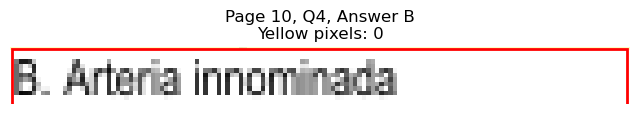

Page 10, Q4 - C: Detected box: x0=315.4, y0=316.6, x1=403.3, y1=329.2
Page 10, Q4, C: Yellow pixels: 0
Page 10, Q4, C: Total non-white pixels: 431
Page 10, Q4, C: Yellow percentage: 0.0%


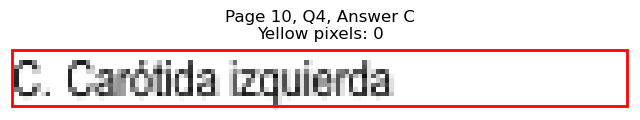

Page 10, Q4 - D: Detected box: x0=315.4, y0=329.2, x1=407.8, y1=341.8
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 418
Page 10, Q4, D: Yellow percentage: 0.0%


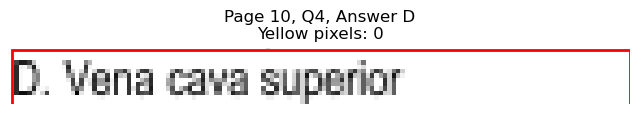


Page 10, Q4 - Selected Answer: A (based on yellow pixel count)
Page 10, Q5 - A: Detected box: x0=56.6, y0=367.1, x1=151.1, y1=379.8
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 599
Page 10, Q5, A: Yellow percentage: 0.0%


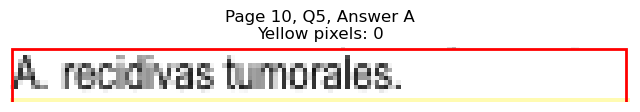

Page 10, Q5 - B: Detected box: x0=56.6, y0=379.7, x1=173.7, y1=392.4
Page 10, Q5, B: Yellow pixels: 1617
Page 10, Q5, B: Total non-white pixels: 2352
Page 10, Q5, B: Yellow percentage: 68.8%


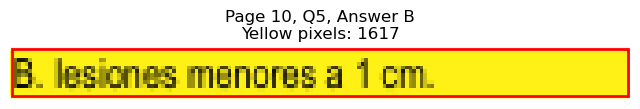

Page 10, Q5 - C: Detected box: x0=315.4, y0=367.1, x1=403.7, y1=379.8
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 421
Page 10, Q5, C: Yellow percentage: 0.0%


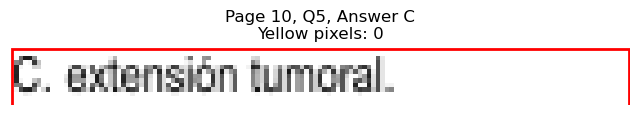

Page 10, Q5 - D: Detected box: x0=315.4, y0=379.7, x1=429.3, y1=392.4
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 566
Page 10, Q5, D: Yellow percentage: 0.0%


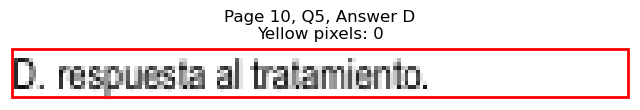


Page 10, Q5 - Selected Answer: B (based on yellow pixel count)
Page 10, Q6 - A: Detected box: x0=56.6, y0=417.6, x1=145.0, y1=430.3
Page 10, Q6, A: Yellow pixels: 139
Page 10, Q6, A: Total non-white pixels: 577
Page 10, Q6, A: Yellow percentage: 24.1%


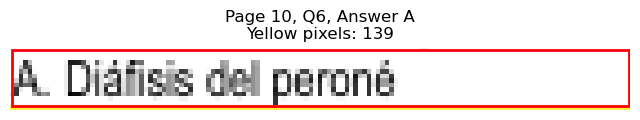

Page 10, Q6 - B: Detected box: x0=56.6, y0=430.2, x1=162.0, y1=442.9
Page 10, Q6, B: Yellow pixels: 1638
Page 10, Q6, B: Total non-white pixels: 2041
Page 10, Q6, B: Yellow percentage: 80.3%


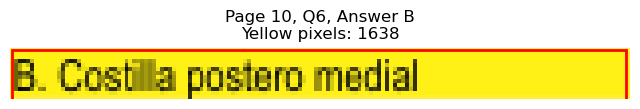

Page 10, Q6 - C: Detected box: x0=315.4, y0=417.6, x1=396.3, y1=430.3
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 389
Page 10, Q6, C: Yellow percentage: 0.0%


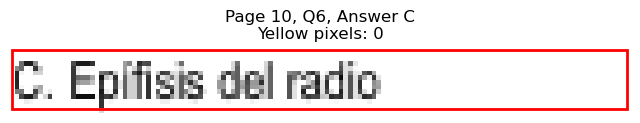

Page 10, Q6 - D: Detected box: x0=315.4, y0=430.2, x1=411.8, y1=442.9
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 462
Page 10, Q6, D: Yellow percentage: 0.0%


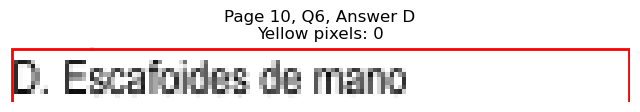


Page 10, Q6 - Selected Answer: B (based on yellow pixel count)
Page 10, Q7 - A: Detected box: x0=56.6, y0=493.4, x1=172.1, y1=506.0
Page 10, Q7, A: Yellow pixels: 1776
Page 10, Q7, A: Total non-white pixels: 2171
Page 10, Q7, A: Yellow percentage: 81.8%


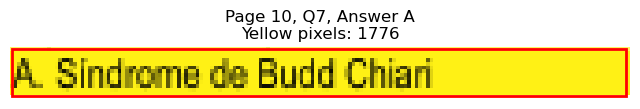

Page 10, Q7 - B: Detected box: x0=56.6, y0=506.0, x1=138.1, y1=518.6
Page 10, Q7, B: Yellow pixels: 133
Page 10, Q7, B: Total non-white pixels: 511
Page 10, Q7, B: Yellow percentage: 26.0%


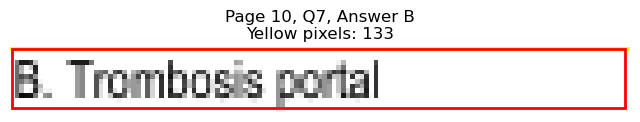

Page 10, Q7 - C: Detected box: x0=315.4, y0=493.4, x1=432.9, y1=506.0
Page 10, Q7, C: Yellow pixels: 0
Page 10, Q7, C: Total non-white pixels: 625
Page 10, Q7, C: Yellow percentage: 0.0%


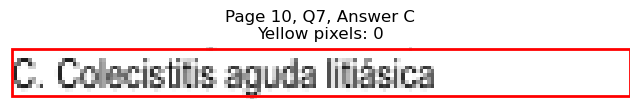

Page 10, Q7 - D: Detected box: x0=315.4, y0=506.0, x1=399.8, y1=518.6
Page 10, Q7, D: Yellow pixels: 0
Page 10, Q7, D: Total non-white pixels: 422
Page 10, Q7, D: Yellow percentage: 0.0%


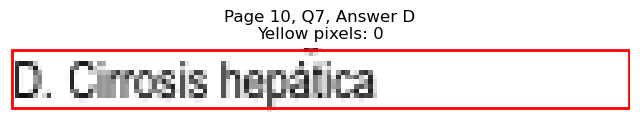


Page 10, Q7 - Selected Answer: A (based on yellow pixel count)


In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Varón de 30 años con ingesta de alcohol frecue...
1   Niña de 7 meses con masa palpable. TC: masa re...
2   Mujer de 35 años con tos y fiebre. Rx de tórax...
3   Paciente con síndrome coronario agudo; el estu...
4   Paciente con antecedente de traumatismo abdomi...
..                                                ...
95  Mujer de 65 años, obesa, con antecedente de ci...
96  En el estudio TC del mediastino supra aórtico,...
97  En el estudio de la patología neoplásica, una ...
98  En un lactante con sospecha de maltrato infant...
99  Varón de 47 años, con antecedente de hipercoag...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                                       Autoinmune   
1                                        Shwannoma   
2                                         Alveolar   
3                             Descendente anterior   
4   Laceración parenquimatosa <1 cm de profundidad   
..                                             ...   
95                             Absceso mediastinal   
96                             Vena braquicefálica   
97                            recidivas tumorales.   
98                             Diáfisis del peroné   
99                         Síndrome de Budd Chiari   

                                             option_B  \
0                                             Crónica   
1                                      Fetus in fetus   
2                                           Reticular   
3                                   Coronaria derecha   
4   Laceración de 1-3 cm de profundidad y ≤10 cm d...   
..                                                ...   
95                                Mediastinitis aguda   
96                                 Arteria innominada   
97                           lesiones menores a 1 cm.   
98                            Costilla postero medial   
99                                   Trombosis portal   

                          option_C  \
0                            Aguda   
1             Linfangioma quístico   
2                Vidrio delustrado   
3                      Circunfleja   
4   Disrupción parenquimatosa >75%   
..                             ...   
95                 Neumomediastino   
96              Carótida izquierda   
97              extensión tumoral.   
98              Epífisis del radio   
99    Colecistitis aguda litiásica   

                                          option_D  
0                                        Del surco  
1                                      Liposarcoma  
2                                        Empedrado  
3                       Interventricular posterior  
4   Disrupción parenquimatosa que afecta al 25-75%  
..                                             ...  
95                                  Hemomediastino  
96                              Vena cava superior  
97                       respuesta al tratamiento.  
98                              Escafoides de mano  
99                               Cirrosis hepática  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               B
1               B
2               A
3               A
4               D
..            ...
95              B
96              A
97              B
98              B
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   Varón de 30 años con ingesta de alcohol frecue...   
1   Niña de 7 meses con masa palpable. TC: masa re...   
2   Mujer de 35 años con tos y fiebre. Rx de tórax...   
3   Paciente con síndrome coronario agudo; el estu...   
4   Paciente con antecedente de traumatismo abdomi...   
..                                                ...   
95  Mujer de 65 años, obesa, con antecedente de ci...   
96  En el estudio TC del mediastino supra aórtico,...   
97  En el estudio de la patología neoplásica, una ...   
98  En un lactante con sospecha de maltrato infant...   
99  Varón de 47 años, con antecedente de hipercoag...   

                                          option_A  \
0                                       Autoinmune   
1                                        Shwannoma   
2                                         Alveolar   
3                             Descendente anterior   
4   Laceración parenquimatosa <1 cm de profundidad   
..                                             ...   
95                             Absceso mediastinal   
96                             Vena braquicefálica   
97                            recidivas tumorales.   
98                             Diáfisis del peroné   
99                         Síndrome de Budd Chiari   

                                             option_B  \
0                                             Crónica   
1                                      Fetus in fetus   
2                                           Reticular   
3                                   Coronaria derecha   
4   Laceración de 1-3 cm de profundidad y ≤10 cm d...   
..                                                ...   
95                                Mediastinitis aguda   
96                                 Arteria innominada   
97                           lesiones menores a 1 cm.   
98                            Costilla postero medial   
99                                   Trombosis portal   

                          option_C  \
0                            Aguda   
1             Linfangioma quístico   
2                Vidrio delustrado   
3                      Circunfleja   
4   Disrupción parenquimatosa >75%   
..                             ...   
95                 Neumomediastino   
96              Carótida izquierda   
97              extensión tumoral.   
98              Epífisis del radio   
99    Colecistitis aguda litiásica   

                                          option_D correct_answer  
0                                        Del surco              B  
1                                      Liposarcoma              B  
2                                        Empedrado              A  
3                       Interventricular posterior              A  
4   Disrupción parenquimatosa que afecta al 25-75%              D  
..                                             ...            ...  
95                                  Hemomediastino              B  
96                              Vena cava superior              A  
97                       respuesta al tratamiento.              B  
98                              Escafoides de mano              B  
99                               Cirrosis hepática              A  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/RADIOLOGÍA.csv
